# BattMo Workshop

The workshop consists of the following parts:
- Hello BattMo: explore the basic features of BattMo.jl


 ---

Let's import BattMo and some other packages into the kernel.

In [ ]:
using BattMo, WGLMakie, Jutul, CSV, DataFrames
GLMakie.activate!(inline=true)

## Part 1 - Hello BattMo

Welcome to this hands-on tutorial where we’ll explore the basics of BattMo.jl — a powerful Julia package for simulating lithium-ion battery cells using physics-based models like the Doyle-Fuller-Newman (DFN) model. 

By the end of this tutorial, you’ll:

- Understand some basic features of BattMo.jl
- Run your first battery simulation
- Explore and visualize the output
- Learn how to tweak key parameters for custom behavior




### a) Input ([docs](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/terminology))

BattMo.jl structures its simulation inputs into two primary categories: Parameters and Settings. This distinction helps users differentiate between the physical characteristics of the battery system and the numerical configurations of the simulation.

**Parameters** represent the controllable variables in real-world experiments. They are further divided into:

- **Cell Parameters**: define the intrinsic properties of the battery cell, such as geometry and material characteristics.
- **Cycling Protocol Parameters**: specify how the cell is operated during a simulation.

**Settings** are used to configure numerical assumptions for solving equations and finding numerical solutions. They are further divided into:

- **Model Settings**: define numerical assumptions related to the battery model, such as diffusion methods or simplifications used in the simulation.
- **Simulation Settings**: define numerical assumptions specific to the simulation process, including time-stepping schemes and discretization precision.
- **Solver Settings**: define solver behavior and verbosity.

**BattMo** stores cell parameters, cycling protocols and settings in a user-friendly JSON format to facilitate reuse. We can load the parameters directly from the default sets which can be very convenient for a quick parameter loading to test a simulation setup. In order to quickly see which default sets BattMo provides we can use the following function to print information about the sets available.

In [71]:
print_default_input_sets()


📋 Overview of Available Default Sets

📁 cell_parameters:         chayambuka_2022, chen_2020, xu_2015
📁 cycling_protocols:       cc_charge, cc_cycling, cc_discharge, cccv, user_defined_current_function
📁 full_simulation_input:   chen_2020, chen_2020_p4d
📁 model_settings:          p2d, p4d_cylindrical, p4d_pouch
📁 simulation_settings:     p2d, p2d_fine_resolution, p4d_cylindrical, p4d_pouch
📁 solver_settings:         default, direct, iterative

📖 Detailed Descriptions

📂 cell_parameters
----------------------------------------------------------------------------------------------------
chayambuka_2022
🔹 Cell name:       	-
🔹 Cell case:       	 
🔹 Source:          	[visit]((Invalid metadata format))

🔹 Suitable for:
   • RampUp:             Sinusoidal
   • TransportInSolid:   FullDiffusion
   • ModelFramework:     P2D
🔹 Description:     	Parameter set for a Sodium ion cell based on Chayambuka et al. The positive electrode open circuit potential has been retrieved from a [COMSOL example](

For our example, we load the cell parameter set from a NMC811 vs Graphite-SiOx cell whose parameters were determined in the [Chen 2020 paper](https://doi.org/10.1149/1945-7111/ab9050). We also load an example cycling protocol for a simple Constant Current Discharge. We can load them directly from the build in sets.

In [72]:
cell_parameters = load_cell_parameters(; from_default_set = "chen_2020");
cycling_protocol = load_cycling_protocol(; from_default_set = "cc_discharge");

This a quick way of testing a setup, but for the purpose of this workshop we would like to be able to see what a parameter set contains. Therefore, we'll retrieve the default parameter sets that BattMo provides and store them locally in a folder. We can do this by running the following script.

In [73]:
path = "."
folder_name = "default_sets"
generate_default_parameter_files(path, folder_name; force = true)

🛠 JSON files successfully written! Path:
	.\default_sets


".\\default_sets"

As we stored the default sets in our own folder, we can alter the default files if we want to and load the parameters from our dedicated folder.

In [74]:
cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/chen_2020.json");
cycling_protocol = load_cycling_protocol(; from_file_path = "default_sets/cycling_protocols/cc_discharge.json");

To change cell parameters, we can modify the JSON files directly, or we can read them into objects in the script and modify them as Dictionaries. A loaded cell parameter set is a Dictionary-like object which come with additional handy functions. First, lets list the outermost keys of the cell parameters object.

In [75]:
cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/chen_2020.json")
keys(cell_parameters)

KeySet for a Dict{String, Any} with 6 entries. Keys:
  "Electrolyte"
  "Cell"
  "Metadata"
  "PositiveElectrode"
  "Separator"
  "NegativeElectrode"

Now we access the Separator key.

In [76]:
cell_parameters["Separator"]

Dict{String, Any} with 5 entries:
  "Description"          => "Ceramic-coated Polyolefin"
  "Density"              => 946
  "BruggemanCoefficient" => 1.5
  "Thickness"            => 1.2e-5
  "Porosity"             => 0.47

We have a flat list of parameters and values for the separator. In other cases, a key might nest other dictionaries, which can be accessed using the normal dictionary notation. Lets for instance see the active material parameters of the negative electrode.

In [77]:
cell_parameters["NegativeElectrode"]["ActiveMaterial"]

Dict{String, Any} with 16 entries:
  "ActivationEnergyOfDiffusion"       => 5000
  "NumberOfElectronsTransfered"       => 1
  "StoichiometricCoefficientAtSOC0"   => 0.0279
  "OpenCircuitPotential"              => "1.9793 * exp(-39.3631*(c/cmax)) + 0.2…
  "ReactionRateConstant"              => 6.716e-12
  "MassFraction"                      => 1.0
  "StoichiometricCoefficientAtSOC100" => 0.9014
  "ActivationEnergyOfReaction"        => 35000
  "MaximumConcentration"              => 33133.0
  "VolumetricSurfaceArea"             => 383959.0
  "Description"                       => "Graphite-SiOx"
  "DiffusionCoefficient"              => 3.3e-14
  "ParticleRadius"                    => 5.86e-6
  "Density"                           => 2260.0
  "ElectronicConductivity"            => 215
  "ChargeTransferCoefficient"         => 0.5

There are many parameters, nested into dictionaries. Often, we are more interested in a specific subset of parameters. We can find a parameter with the search_parameter function. For example, we'd like to now how area related parameters are named:

In [78]:
search_parameter(cell_parameters, "area")


Parameters
------------------
[ "NegativeElectrode" ][ "ActiveMaterial" ][ "VolumetricSurfaceArea" ] => 383959.0
[ "PositiveElectrode" ][ "ActiveMaterial" ][ "VolumetricSurfaceArea" ] => 383959.0
[ "Cell" ][ "ElectrodeGeometricSurfaceArea" ] => 0.1027


Another way to view our parameters is by printing info about the parameter set.

In [79]:
print_info(cell_parameters)


PARAMETER OVERVIEW
Parameter                                                                                 Unit                Type                Value                         
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[ "Cell" ][ "Case" ]                                                                      N/A                 String              Cylindrical                   
[ "Cell" ][ "ElectrodeGeometricSurfaceArea" ]                                             m²                  Float64             0.1027                        
[ "Cell" ][ "Height" ]                                                                    m                   Float64             0.065                         
[ "Cell" ][ "InnerRadius" ]                                                               m                   Float64             0.002                         
[ "Cell" ][ "N

Parameters that take single numerical values (e.g. real, integers, booleans) can be directly modified.

In [80]:
cell_parameters["PositiveElectrode"]["Coating"]["Thickness"] = 8.2e-5

8.2e-5

Some parameters are described as functions or arrays, since the parameter value depends on other variables. For instance the Open Circuit Potentials of the Active Materials depend on the lithium stoichiometry and temperature. When we're unsure about the type or meaning of a parameter, we can print information on invidual parameters as well. For some parameters, that require more explanation, a link to the documentation is provided. Visit the documentation of the OpenCircuitPotential parameter to find more information on how to implement you own user defined functional parameters.

In [81]:
parameter_name = "OpenCircuitPotential"

print_info(parameter_name, view = "CellParameters")


----------------------------------------------------------------------------------------------------
🔋  Cell Parameter:  OpenCircuitPotential
----------------------------------------------------------------------------------------------------
    🔹 Name               OpenCircuitPotential
    🔹 Category           CellParameters
    🔹 Description        The open-circuit potential of the active material under a given intercalant stoichimetry and temperature.
    🔹 Type               String, Dict{String, Vector}, Real
    🔹 Unit               V
    🔹 Documentation      [visit](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/simulation_dependent_input)

    🔹 Ontology link      [visit](https://w3id.org/emmo/domain/electrochemistry#electrochemistry_9c657fdc_b9d3_4964_907c_f9a6e8c5f52b)




The cycling protocol parameters and the settings (model settings, simulation settings, solver settings) can be loaded, viewed and altered in the same way as the cell parameters. Let's load a default CCCV cycling protocol. The settings we'll go into later.

In [82]:
cycling_protocol = load_cycling_protocol(; from_file_path= "default_sets/cycling_protocols/cccv.json");
print_info(cycling_protocol)


PARAMETER OVERVIEW
Parameter                                                                                 Unit                Type                Value                         
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[ "CRate" ]                                                                               1                   Float64             1.0                           
[ "CurrentChangeLimit" ]                                                                  A·s⁻¹               Float64             0.0001                        
[ "DRate" ]                                                                               1                   Float64             1.0                           
[ "InitialControl" ]                                                                      N/A                 String              charging                      
[ "InitialStat

### b) Run a simulation ([docs](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/public_api))

In this part we'll show how you can run a simple P2D simulation. Let's start by loading the Chen 2020 cell parameter set and a constant current discharge cycling protocol.

In [83]:
cell_parameters = load_cell_parameters(; from_default_set = "chen_2020");
cycling_protocol = load_cycling_protocol(; from_default_set = "cc_discharge");

Next, we select the default Lithium-Ion Battery model. A model can be thought as a mathematical implementation of the electrochemical and transport phenomena occuring in a real battery cell. The implementation consist of a system of partial differential equations and their corresponding parameters, constants and boundary conditions. The default Lithium-Ion Battery setup selected below contains the model settings to simulate a basic P2D model, where neither current collectors nor SEI growth are considered.

In [84]:
model = LithiumIonBattery();

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────


The LithiumIonBattery constructor validates the model settings on the back ground. If the model setup is valid we can continue and create a Simulation object by passing the model setup, cell parameters and a cycling protocol.

In [85]:
sim = Simulation(model, cell_parameters, cycling_protocol);

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────


The simulation object is only instantiated when the model provided is valid. We can see that the Simulation object also validates the parameters and settings on the back ground. Each parameter set is validated on whether they are sensible and complete. 

When the Simulation object is valid we can solve the simulation by passing the object to the solve function. As Julia is a compiled language, the first time that we run a simulation it will take some time to compile the functions and structs that it encounters. This makes running a second simulation very fast. See the difference by running the script for a second time.

In [86]:
output = solve(sim);

✔️ Validation of SolverSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress   8%|████                                       |  ETA: 0:00:01

Progress  18%|████████                                   |  ETA: 0:00:01

Progress  29%|█████████████                              |  ETA: 0:00:01

Progress  40%|██████████████████                         |  ETA: 0:00:01

Progress  48%|█████████████████████                      |  ETA: 0:00:01

Progress  57%|█████████████████████████                  |  ETA: 0:00:01

Progress  65%|█████████████████████████████              |  ETA: 0:00:00

Progress  71%|███████████████████████████████            |  ETA: 0:00:00

Progress  78%|██████████████████████████████████         |  ETA: 0:00:00

Progress  86%|█████████████████████████████████████      |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:01


╭────────────────┬───────────┬───────────────┬──────────╮
│ Iteration type │  Avg/step │  Avg/ministep │    Total │
│                │ 146 steps │ 146 ministeps │ (wasted) │
├────────────────┼───────────┼───────────────┼──────────┤
│ Newton         │   2.32192 │       2.32192 │  339 (0) │
│ Linearization  │   3.32192 │       3.32192 │  485 (0) │
│ Linear solver  │   2.32192 │       2.32192 │  339 (0) │
│ Precond apply  │       0.0 │           0.0 │    0 (0) │
╰────────────────┴───────────┴───────────────┴──────────╯
╭───────────────┬────────┬────────────┬────────╮
│ Timing type   │   Each │   Relative │  Total │
│               │     ms │ Percentage │      s │
├───────────────┼────────┼────────────┼────────┤
│ Properties    │ 0.1052 │     2.85 % │ 0.0357 │
│ Equations     │ 1.1584 │    44.91 % │ 0.5618 │
│ Assembly      │ 0.1910 │     7.41 % │ 0.0927 │
│ Linear solve  │ 1.0781 │    29.21 % │ 0.3655 │
│ Linear setup  │ 0.0000 │     0.00 % │ 0.0000 │
│ Precond apply │ 0.0000 │     0.00 %

We can use some built in functions for quick plotting. The dashboard gives you a quick overview of some important ouput variables. You can choose to have interactive line plots where you can change the time step using a slider or contour plots that show the position and time in one plot.

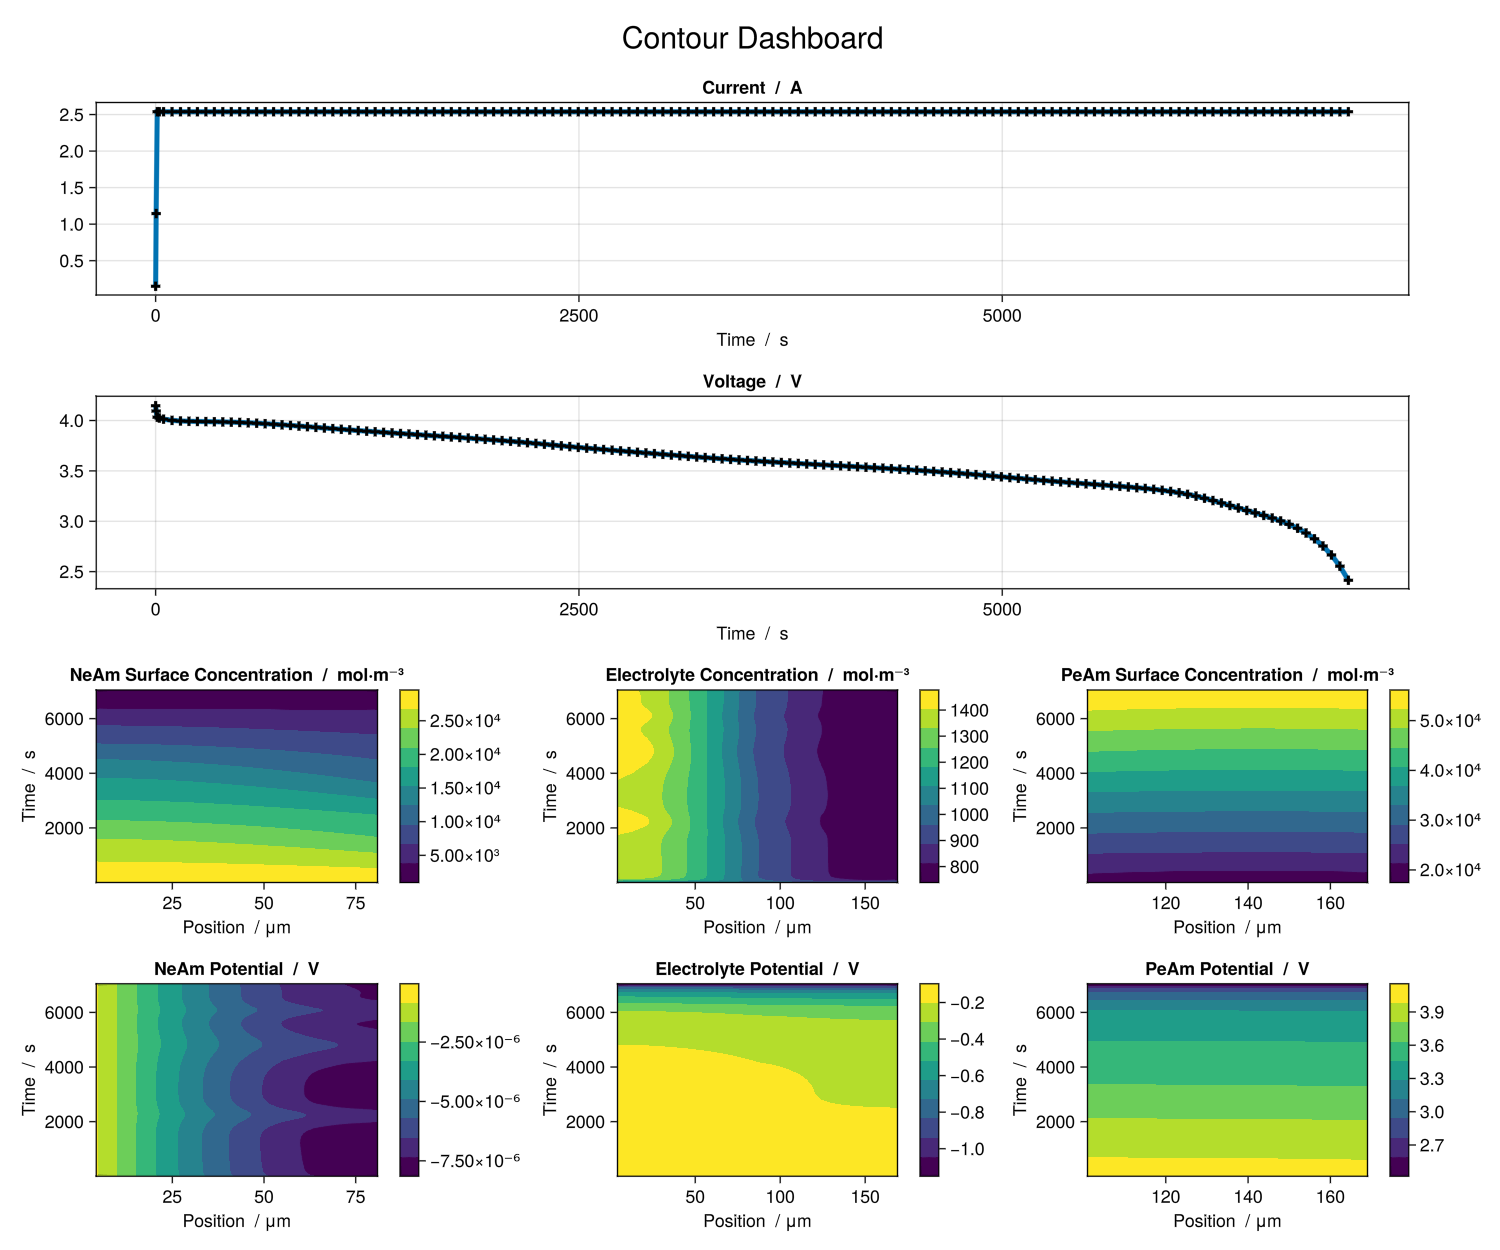

In [87]:
plot_dashboard(output; plot_type="contour")

As the line plot is an interactive plot and notebooks are not able to render interactive plots, we'll show it in a separate window. 

In [88]:
GLMakie.activate!(inline=false)

plot_dashboard(output; plot_type="line")

### c) Output ([docs](https://battmoteam.github.io/BattMo.jl/dev/tutorials/3_handle_outputs))

In BattMo.jl the output variables are divided into three different categories:
- **time series**: all variables that depent on time.
- **states**: all the state variables, which can be dependent on time, axial position and radial position.
- **metrics**: the calculated cell metrics, dependent on the cycle index.

In order to investigate how to retrieve output quantities, let's simulate a couple of constant current constant voltage cycles.

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SolverSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 days, 2 hours as 3600 report steps


Progress   0%|█                                          |  ETA: 0:00:49

Progress   0%|█                                          |  ETA: 0:01:01

Progress   1%|█                                          |  ETA: 0:00:35

Progress   2%|█                                          |  ETA: 0:00:50

Progress   2%|█                                          |  ETA: 0:02:01

Progress   3%|██                                         |  ETA: 0:01:21

Progress   3%|██                                         |  ETA: 0:01:08

Progress   4%|██                                         |  ETA: 0:01:00

Progress   5%|███                                        |  ETA: 0:00:52

Progress   6%|███                                        |  ETA: 0:00:45

Progress   6%|███                                        |  ETA: 0:00:42

Progress   7%|████                                       |  ETA: 0:00:42

Progress   7%|████                                       |  ETA: 0:00:40

Progress   8%|████                    

╭────────────────┬────────────┬────────────────┬─────────────╮
│ Iteration type │   Avg/step │   Avg/ministep │       Total │
│                │ 2599 steps │ 2717 ministeps │    (wasted) │
├────────────────┼────────────┼────────────────┼─────────────┤
│ Newton         │    2.73451 │        2.61575 │ 7107 (1620) │
│ Linearization  │    3.77992 │        3.61575 │ 9824 (1701) │
│ Linear solver  │    2.73451 │        2.61575 │ 7107 (1620) │
│ Precond apply  │        0.0 │            0.0 │       0 (0) │
╰────────────────┴────────────┴────────────────┴─────────────╯
╭───────────────┬────────┬────────────┬─────────╮
│ Timing type   │   Each │   Relative │   Total │
│               │     ms │ Percentage │       s │
├───────────────┼────────┼────────────┼─────────┤
│ Properties    │ 0.0852 │     2.77 % │  0.6052 │
│ Equations     │ 1.0313 │    46.29 % │ 10.1317 │
│ Assembly      │ 0.1353 │     6.07 % │  1.3288 │
│ Linear solve  │ 0.9744 │    31.64 % │  6.9251 │
│ Linear setup  │ 0.0000 │     0.

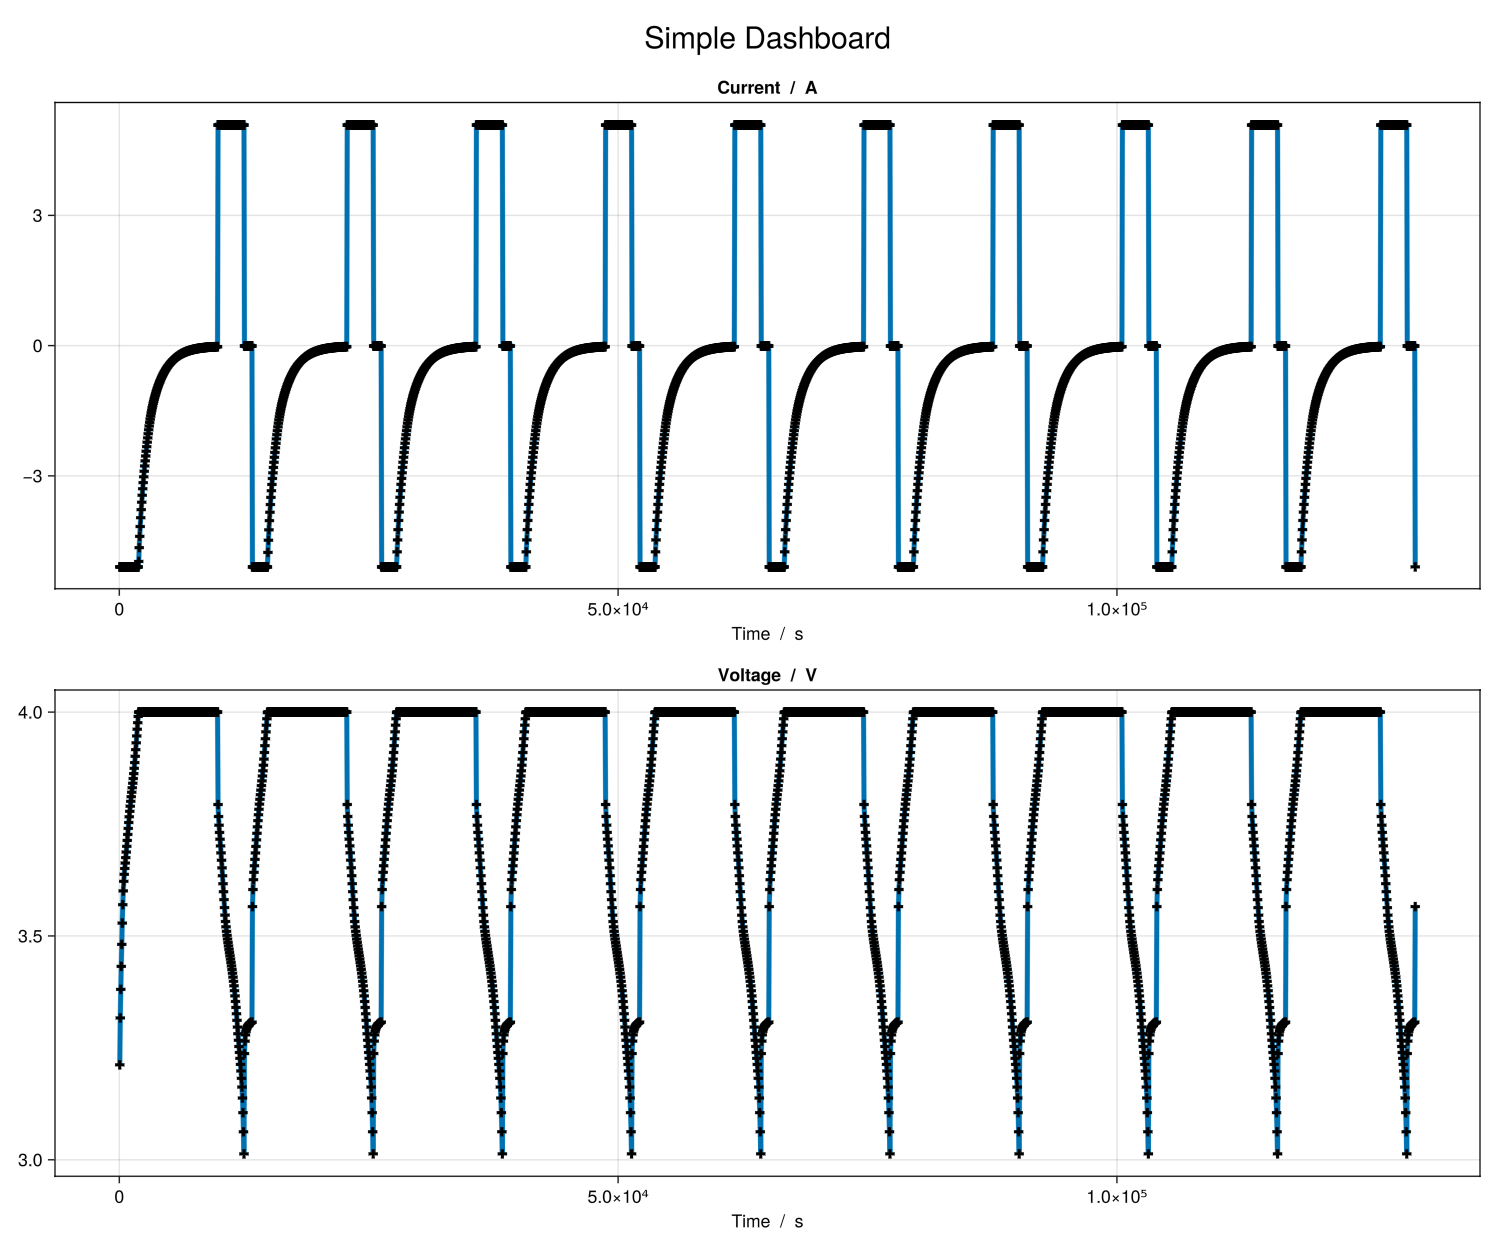

In [89]:
cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/chen_2020.json")
cycling_protocol = load_cycling_protocol(; from_file_path = "default_sets/cycling_protocols/cccv.json")

cycling_protocol["TotalNumberOfCycles"] = 10

model_setup = LithiumIonBattery()

sim = Simulation(model_setup, cell_parameters, cycling_protocol);

output = solve(sim);

GLMakie.activate!(inline=true)
plot_dashboard(output, plot_type = "simple")

Let's use the output from the previous CCCV simulation. We can again use the print info function to have a look into which output variables are available.

In [90]:
print_info(output)


Case: TIME_SERIES
Variable                                                         Unit                          Shape
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Capacity                                                         Ah                            (nTime,)
Current                                                          A                             (nTime,)
CycleNumber                                                      1                             (nTime,)
Time                                                             s                             (nTime,)
Voltage                                                          V                             (nTime,)

Case: METRICS
Variable                                                         Unit                          Shape
-----------------------------------------------------------------------------------

In the overview we can quickly see the aivalable variables and their units. We can also see that the variables have been devided into three categories like explained above: time series, states, and metrics. This has been done to provide some structure to the variables that is intuitive and cleans up the data. We also use these three categories when retrieving data. Let's first retrieve for example time series data like voltage, current and time.

In [91]:
time_series = output.time_series

t = time_series["Time"]
E = time_series["Voltage"]
I = time_series["Current"];

Let's now retrieve some state variables

In [92]:
states = output.states

electrolyte_concentration = states["ElectrolyteConcentration"]
electrolyte_potential = states["ElectrolytePotential"];

We can also print more information on each individual variable. For example, to look into the difference between the electrode particle concentration and surface concentration.

In [93]:
print_info("NegativeElectrodeActiveMaterialParticleConcentration")


----------------------------------------------------------------------------------------------------
📈  Output Variable:  NegativeElectrodeActiveMaterialParticleConcentration
----------------------------------------------------------------------------------------------------
    🔹 Name               NegativeElectrodeActiveMaterialParticleConcentration
    🔹 Category           OutputVariable
    🔹 Description        Radial distribution of lithium concentration in negative electrode particles.
    🔹 Type               Vector{Real}
    🔹 Shape              (nTime, nPosition, nNegativeElectrodeActiveMaterialRadius)
    🔹 Unit               mol·L⁻¹



In [94]:
print_info("NegativeElectrodeActiveMaterialSurfaceConcentration")


----------------------------------------------------------------------------------------------------
📈  Output Variable:  NegativeElectrodeActiveMaterialSurfaceConcentration
----------------------------------------------------------------------------------------------------
    🔹 Name               NegativeElectrodeActiveMaterialSurfaceConcentration
    🔹 Category           OutputVariable
    🔹 Description        Concentration of lithium ions at the surface of negative electrode particles.
    🔹 Type               Vector{Real}
    🔹 Shape              (nTime, nPosition)
    🔹 Unit               mol·L⁻¹



We can have a better idea of what the variable represents by reading the description and checking the shape of the variable. We can also retrieve some metrics from the output.

In [95]:
metrics = output.metrics

discharge_capacity = metrics["DischargeCapacity"]
round_trip_efficiency = metrics["RoundTripEfficiency"]
cycle_index = metrics["CycleIndex"]

10-element Vector{Int64}:
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9

Let's plot the discharge capacity against its cycle index.

In [96]:

f = Figure(size = (1000, 400))

ax = Axis(f[1, 1], title = "Round trip efficiency", xlabel = "Cycle number / -", ylabel = "Efficiency / %",
)
scatterlines!(ax, cycle_index, round_trip_efficiency; linewidth = 4)

ax = Axis(f[2, 1], title = "Discharge capacity", xlabel = "Cycle number / -", ylabel = "Capacity / Ah",
)
scatterlines!(ax, cycle_index, discharge_capacity; linewidth = 4)

f

TaskFailedException: TaskFailedException

    nested task error: GLFWError (PLATFORM_ERROR): WGL: Failed to make context current: The operation completed successfully. 
    Stacktrace:
     [1] _ErrorCallbackWrapper(code::Int32, description::Cstring)
       @ GLFW C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\callback.jl:46
     [2] MakeContextCurrent
       @ C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\glfw3.jl:841 [inlined]
     [3] native_switch_context!
       @ C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\glwindow.jl:223 [inlined]
     [4] switch_context!
       @ C:\Users\lorenah\.julia\packages\ShaderAbstractions\BCZHP\src\context.jl:51 [inlined]
     [5] pollevents(screen::GLMakie.Screen{GLFW.Window}, frame_state::Makie.TickState)
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:545
     [6] on_demand_renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1038
     [7] renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1066
     [8] (::GLMakie.var"#start_renderloop!##0#start_renderloop!##1"{GLMakie.Screen{GLFW.Window}})()
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:927

## Part 2 - Normal workflows

In this tutorial we'll explore some normal workflows that require a bit more advanced use than the Hello BattMo tutorial. Within this tutorial you will:
- Learn how to create your own parameter sets
- Simulate a WLTP drive cycle to learn how to define your own parameter functions
- Implement electrode balancing to a simulation
- Investigate the influence of the reaction rate and diffusion coefficient on cell performance

### a) - Create your own parameter sets

This part of the tutorial walks you through the process of creating and customizing your own cell parameter sets in BattMo.jl. Cell parameter sets define the physical and chemical properties of the battery system you're simulating. You can build them from scratch using your model setup, modify them, and save them for future use.

The difficulty with setting up your own input parameters are that it's often not very clear which parameters you need for which submodel combination. In BattMo we have created a handy system to assist you in this process and bring more clearity in the parameter-model relations. We do this by providing functions that create empty parameter sets containing the required parameters based on the user's defined model setup.

Let's get into it!

#### Step 1 - Initiate a model setup

First, define the battery model configuration you'd like to use. This will serve as the template for generating your parameter set. Model settings specify the submodels that the user would like to be included within the simulation. Have a quick look into the submodels that you can configure by running the following function.

In [97]:
print_submodels()

ℹ️  Submodels Information
Parameter                     Options                                           Documentation
----------------------------------------------------------------------------------------------------
ButlerVolmer                  Standard, Chayambuka                              [visit](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/pxd_model)

CurrentCollectors             Standard                                          -         
SEIModel                      Bolay                                             [visit](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/sei_model)

RampUp                        Sinusoidal                                        [visit](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/ramp_up)

TemperatureDependence         Arrhenius                                         [visit](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/arrhenius)

PotentialFlowDiscretization   GeneralAD, T

Let's say we'd like to setup our own cell parameter set that includes parameters for a P2D simulation including SEI growth. Then we first configure the model. We can start from the default P2D model settings.

In [98]:
model_settings = load_model_settings(; from_file_path= "default_sets/model_settings/p2d.json")

print_info(model_settings)


PARAMETER OVERVIEW
Parameter                                                                                 Unit                Type                Value                         
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[ "ButlerVolmer" ]                                                                        N/A                 String              Standard                      
[ "ModelFramework" ]                                                                      N/A                 String              P2D                           
[ "PotentialFlowDiscretization" ]                                                         N/A                 String              GeneralAD                     
[ "RampUp" ]                                                                              N/A                 String              Sinusoidal                    
[ "TransportIn

We can see that these settings don't include the SEI model. So let's add it. 

In [99]:

model_settings["SEIModel"] = "Bolay"

print_info(model_settings)


PARAMETER OVERVIEW
Parameter                                                                                 Unit                Type                Value                         
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[ "ButlerVolmer" ]                                                                        N/A                 String              Standard                      
[ "ModelFramework" ]                                                                      N/A                 String              P2D                           
[ "PotentialFlowDiscretization" ]                                                         N/A                 String              GeneralAD                     
[ "RampUp" ]                                                                              N/A                 String              Sinusoidal                    
[ "SEIModel" ]

We can now instantiate the lithium ion battery model and see if our model settings are valid.

In [100]:
model_setup = LithiumIonBattery(; model_settings);

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────


#### Step 2 - load an empty parameter set

Next, create an empty parameter dictionary based on your model. This will include all the required keys but without any values filled in.

In [101]:
empty_cell_parameter_set = load_cell_parameters(; from_model_template = model_setup)

print_info(empty_cell_parameter_set)


PARAMETER OVERVIEW
Parameter                                                                                 Unit                Type                Value                         
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[ "Cell" ][ "ElectrodeGeometricSurfaceArea" ]                                             m²                  Float64             0.0                           
[ "Electrolyte" ][ "ChargeNumber" ]                                                       1                   Float64             0.0                           
[ "Electrolyte" ][ "Concentration" ]                                                      mol·m⁻³             Float64             0.0                           
[ "Electrolyte" ][ "Density" ]                                                            kg·m⁻³              Float64             0.0                           
[ "Electrolyte

Let's see if it indeed cotains the SEI input parameters. Parameters that describe the SEI growth are part of the interphase parameters.

In [102]:
empty_cell_parameter_set["NegativeElectrode"]["Interphase"]

Dict{Any, Any} with 7 entries:
  "ElectronicDiffusionCoefficient" => 0.0
  "InterstitialConcentration"      => 0.0
  "InitialThickness"               => 0.0
  "IonicConductivity"              => 0.0
  "StoichiometricCoefficient"      => 0.0
  "InitialPotentialDrop"           => 0.0
  "MolarVolume"                    => 0.0

#### Step 3 - Save the empty set to a JSON file

You can now write this empty set to a JSON file so you can alter it and reuse it later on. 

In [103]:
file_path = "my_custom_parameters.json"
write_to_json_file(file_path, empty_cell_parameter_set)

Data successfully written to my_custom_parameters.json


#### Step 4 - Let BattMo help you fill the empty set

If you're unsure about what a specific parameter means or how it should be formatted, BattMo provides a helpful function to inspect any parameter.

In [104]:
print_info("OpenCircuitPotential", view = "CellParameters")


----------------------------------------------------------------------------------------------------
🔋  Cell Parameter:  OpenCircuitPotential
----------------------------------------------------------------------------------------------------
    🔹 Name               OpenCircuitPotential
    🔹 Category           CellParameters
    🔹 Description        The open-circuit potential of the active material under a given intercalant stoichimetry and temperature.
    🔹 Type               String, Dict{String, Vector}, Real
    🔹 Unit               V
    🔹 Documentation      [visit](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/simulation_dependent_input)

    🔹 Ontology link      [visit](https://w3id.org/emmo/domain/electrochemistry#electrochemistry_9c657fdc_b9d3_4964_907c_f9a6e8c5f52b)




In [105]:
print_info("concentration")


----------------------------------------------------------------------------------------------------
🔋  Cell Parameter:  InterstitialConcentration
----------------------------------------------------------------------------------------------------
    🔹 Name               InterstitialConcentration
    🔹 Category           CellParameters
    🔹 Description        Amount of neutral intersticial sites of the intercalant (Li+) per volume of solid. See https://doi.org/10.1002/cssc.201800077.
    🔹 Type               Real
    🔹 Unit               mol·m⁻³
    🔹 Minimum value      0.0
    🔹 Maximum value      100000.0

----------------------------------------------------------------------------------------------------
🔋  Cell Parameter:  MaximumConcentration
----------------------------------------------------------------------------------------------------
    🔹 Name               MaximumConcentration
    🔹 Category           CellParameters
    🔹 Description        The saturation concentratio

The automatic validation when initiating the Simulation object can help you keep track of your progress on filling in the parameter values and find any values that are unrealistic.

In [106]:
cell_parameters = load_cell_parameters(; from_file_path= "my_custom_parameters.json")


sim = Simulation(model_setup, cell_parameters, load_cycling_protocol(;from_default_set= "cc_discharge"));

🔍 Validation of CellParameters failed with 35 issues:

──────────────────────────────────────────────────
──────────────────────────────────────────────────
Issue 1:
📍 Where:       [Electrolyte][TransferenceNumber]
🔢 Provided:    0.0
🔑 Rule:        minimum = 0.01
🛠  Issue:       Value is below the minimum allowed (0.01)

──────────────────────────────────────────────────
Issue 2:
📍 Where:       [Electrolyte][Density]
🔢 Provided:    0.0
🔑 Rule:        minimum = 0.01
🛠  Issue:       Value is below the minimum allowed (0.01)

──────────────────────────────────────────────────
Issue 3:
📍 Where:       [Electrolyte][ChargeNumber]
🔢 Provided:    0.0
🔑 Rule:        minimum = 1
🛠  Issue:       Value is below the minimum allowed (1)

──────────────────────────────────────────────────
Issue 4:
📍 Where:       [Cell][ElectrodeGeometricSurfaceArea]
🔢 Provided:    0.0
🔑 Rule:        minimum = 0.0001
🛠  Issue:       Value is below the minimum allowed (0.0001)

─────────────────────────────────────────

ErrorException: Oops! Your Simulation object cannot be configured because some of you input is not valid. 🛑

Check the warnings to see where things went wrong. 🔍



>Now you know how you can create your own input files! 

### b) Create your own parameter function

For some parameters you can define your own function in a Julia script and pass it to BattMo. This is available for the following parameters:

**Cell parameters**
- OpenCircuitPotential (negative and positive electrode)
- DiffusionCoefficient (negative and positive electrode)
- ReactionRateConstant (negative and positive electrode)
- DiffusionCoefficient (electrolyte)
- Conductivity (electrolyte)

**Cycling protocol parameters**
- Current

Let have a look into how we can implement this.

For the cell parameters we can have a look at the default cell parameter set "Xu2015.json". Open this parameter set and have a look at how the open circuit potential is defined.

In [107]:
cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/xu_2015.json")

cell_parameters["NegativeElectrode"]["ActiveMaterial"]["OpenCircuitPotential"]

Dict{String, Any} with 2 entries:
  "FilePath"     => "function_parameters_Xu2015.jl"
  "FunctionName" => "open_circuit_potential_graphite_Xu_2015"

We can see that the OpenCircuitPotential in this case has a value of type Dict containing the following keys:
- **FilePath**: the path to the julia script containing the function (relative to the json file)
- **FunctionName**: the name of the function

When running a simulation, BattMo will be able to access the julia script and import the functions defined within that script into the name space so that they can be used for calculating the quantity internally.

An even easier way to do it is to define a function, doesn't matter where, and import it into Main which is the namespace that BattMo can access during a simulation. You can then either define the function within the main script that you're running or define it in a separate script and include that script into your main script.

Let's go through a fun example for setting up your own current function to see how you put this into practice.

#### Current function

For this example we'll use Worldwide harmonized Light vehicles Test Procedure (WLTP) drive cycle data that is stored within "wltp_data/wltp.csv". In order to create a current function from this data we'll have to undergo a couple of steps:
1. Read the time and power data from the CSV.
2. Create an interpolation object from the data.
3. Define a function that returns the current calculated from the interpolated object.

The following code describes these four steps. Running this script will create the function so that BattMo can access it. If you'd like more structure in your files or keep the input functions separate from your main script, you can define the code into a separate Julia file and use `include("curren_function_script.jl")` to import the function into you main script.

In [108]:
####################################################################################################
# An example of a user defined current function using WLTP data from https://github.com/JRCSTU/wltp

using CSV:CSV
using DataFrames
using Jutul:Jutul

# 1. Read data
path = joinpath(@__DIR__, "data","wltp.csv")
df = CSV.read(path, DataFrame)

t = df[:, 1]
P = df[:, 2]


# 2. Use a Jutul interpolator to create an interpolation object of the time and power data
power_func = Jutul.get_1d_interpolator(t, P, cap_endpoints = false)


# 3. Define a function to calculate the current. The current function has to accept time and voltage as arguments.
function wltp_current(time, voltage)

	factor = 4000 # Tot account for the fact that we're simulating a single cell instead of a battery pack

	return power_func(time) / voltage / factor
end


wltp_current (generic function with 1 method)

Now that we have imported our function into Main, we need to create a cycling protocol parameter file that passes the function name to BattMo. The cycling protocols in BattMo are categorized by the parameter "Protocol". Let's get a bit more information on the parameter.

In [109]:
print_info("Protocol")


----------------------------------------------------------------------------------------------------
🚴  Cycling Protocol:  Protocol
----------------------------------------------------------------------------------------------------
    🔹 Name               Protocol
    🔹 Category           CyclingProtocol
    🔹 Description        Type of cycling procedure used to cycle a cell. For instance: Constant Current ("CC"), Constant Current - Constant Voltage ("CCCV").
    🔹 Type               String
    🔹 Options            CC, CCCV, Function
    🔹 Ontology link      [visit](https://w3id.org/emmo/domain/electrochemistry#electrochemistry_d3e2d213_d078_4b9a_8beb_62f063e57d69)




We can see that the paramater Protocol can have three different values: CC, CCCV, or Function. In our case, we want to define our own current function so we'll need to specify Protocol as "Function". Let's use the default cycling protocol parameter set "user_defined_current_function.json" and adapt it to our case.

In [110]:
current_function = load_cycling_protocol(; from_file_path = "default_sets/cycling_protocols/user_defined_current_function.json")

print_info(current_function)


PARAMETER OVERVIEW
Parameter                                                                                 Unit                Type                Value                         
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[ "FunctionName" ]                                                                        N/A                 String              current_function              
[ "InitialStateOfCharge" ]                                                                1                   Float64             0.99                          
[ "Protocol" ]                                                                            N/A                 String              Function                      
[ "TotalTime" ]                                                                           s                   Int64               1800                          
Total paramete

We need to change the function name. The other parameters we can leave them as they are for now.

In [111]:
current_function["FunctionName"] = "wltp_current"

"wltp_current"

We can now write the altered cycling protocol data to a new json file so that we can reuse it in the future.

In [112]:
file_path = "default_sets/cycling_protocols/wltp_protocol.json"
write_to_json_file(file_path, current_function)

Data successfully written to default_sets/cycling_protocols/wltp_protocol.json


Now we can run a simulation using the json file we just created as input for the cycling protocol

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SolverSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 30 minutes as 36 report steps


Progress  54%|████████████████████████                   |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00
   Progress: Solved step 36/36
      Stats: 117 iterations in 227.52 ms (1.94 ms each)


╭────────────────┬──────────┬──────────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │    Total │
│                │ 36 steps │ 36 ministeps │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┤
│ Newton         │     3.25 │         3.25 │  117 (0) │
│ Linearization  │     4.25 │         4.25 │  153 (0) │
│ Linear solver  │     3.25 │         3.25 │  117 (0) │
│ Precond apply  │      0.0 │          0.0 │    0 (0) │
╰────────────────┴──────────┴──────────────┴──────────╯
╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │     ms │ Percentage │       ms │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.1401 │     7.20 % │  16.3868 │
│ Equations     │ 0.7268 │    48.88 % │ 111.2048 │
│ Assembly      │ 0.1008 │     6.78 % │  15.4272 │
│ Linear solve  │ 0.4365 │    22.45 % │  51.0714 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0.0000 │     0.00 %

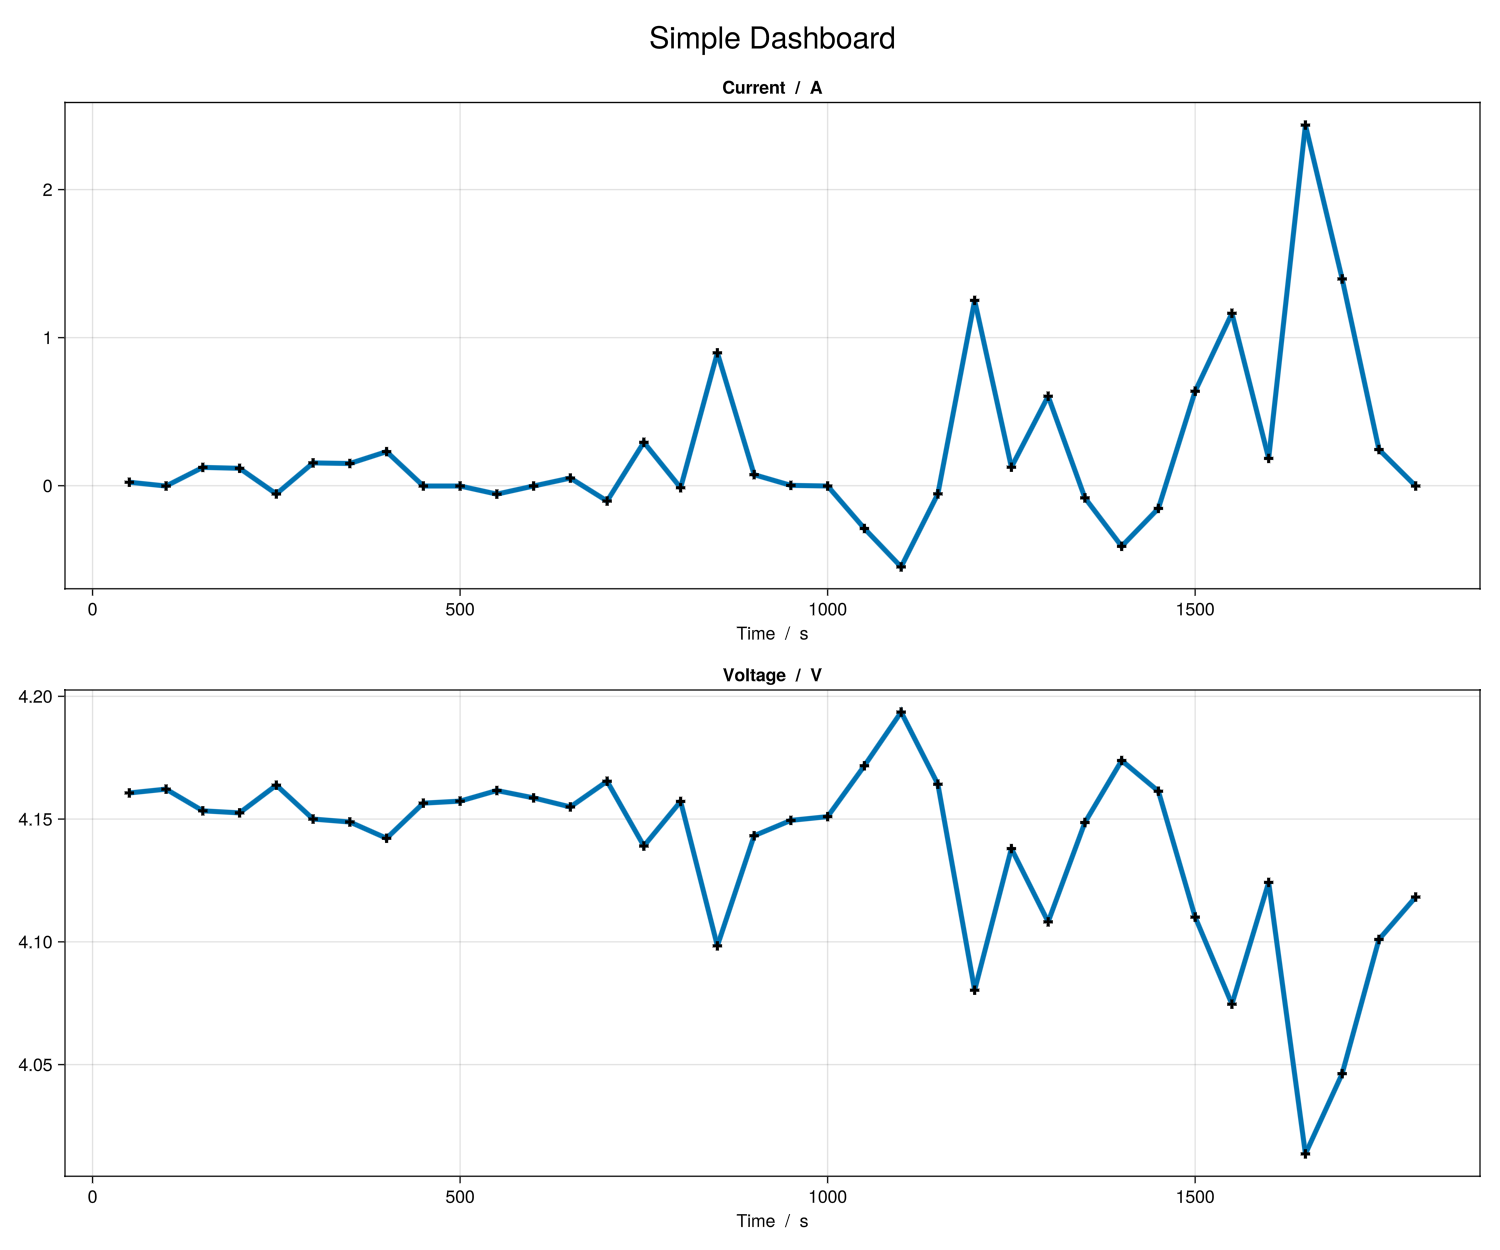

In [113]:

cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/chen_2020.json")
cycling_protocol = load_cycling_protocol(; from_file_path= "default_sets/cycling_protocols/wltp_protocol.json")

model_setup = LithiumIonBattery()

sim = Simulation(model_setup, cell_parameters, cycling_protocol);

output = solve(sim);

plot_dashboard(output)

We can see that the output curves don't look smooth at all. Probably our time resolution isn't small enough. Let's look into changing the simulation setting that determines this. We can print the time related settings to find the right setting that we need to alter.

In [114]:
print_info("time", view = "SimulationSettings")


----------------------------------------------------------------------------------------------------
◻️  Simulation Setting:  TimeStepDuration
----------------------------------------------------------------------------------------------------
    🔹 Name               TimeStepDuration
    🔹 Category           SimulationSettings
    🔹 Description        Duration of each time step in simulations
    🔹 Type               Real
    🔹 Unit               s
    🔹 Minimum value      1
    🔹 Maximum value      500
    🔹 Ontology link      [visit](https://w3id.org/emmo/domain/electrochemistry#electrochemistry_85e39686_9658_4c74_bb91_a935704c174a)


----------------------------------------------------------------------------------------------------
◻️  Simulation Setting:  RampUpTime
----------------------------------------------------------------------------------------------------
    🔹 Name               RampUpTime
    🔹 Category           SimulationSettings
    🔹 Description        Ramp up ti

We can see that the time step duration is the one we need. Until now, we have only used the default simulation settings. Let's see what the default value of the "TimeStepDuration" is.

In [115]:
sim.settings["TimeStepDuration"]

50

It is equal to 50 seconds. Let's refine the time resolution and set it to 1 second. We need to load the default simulation settings first.

In [116]:
simulation_settings = load_simulation_settings(; from_file_path = "default_sets/simulation_settings/p2d.json")
simulation_settings["TimeStepDuration"] = 1

1

We can pass the simulation settings to the Simulation object and run the new simulation.

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SolverSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 30 minutes as 1800 report steps


Progress   1%|█                                          |  ETA: 0:00:14

Progress   1%|█                                          |  ETA: 0:00:16

Progress   2%|█                                          |  ETA: 0:00:17

Progress   3%|██                                         |  ETA: 0:00:14

Progress   4%|██                                         |  ETA: 0:00:15

Progress   5%|███                                        |  ETA: 0:00:13

Progress   6%|███                                        |  ETA: 0:00:12

Progress   8%|████                                       |  ETA: 0:00:11

Progress   9%|█████                                      |  ETA: 0:00:11

Progress  10%|█████                                      |  ETA: 0:00:11

Progress  11%|█████                                      |  ETA: 0:00:11

Progress  12%|██████                                     |  ETA: 0:00:11

Progress  14%|██████                                     |  ETA: 0:00:11

Progress  15%|███████                 

╭────────────────┬────────────┬────────────────┬──────────╮
│ Iteration type │   Avg/step │   Avg/ministep │    Total │
│                │ 1800 steps │ 1800 ministeps │ (wasted) │
├────────────────┼────────────┼────────────────┼──────────┤
│ Newton         │    2.70278 │        2.70278 │ 4865 (0) │
│ Linearization  │    3.70278 │        3.70278 │ 6665 (0) │
│ Linear solver  │    2.70278 │        2.70278 │ 4865 (0) │
│ Precond apply  │        0.0 │            0.0 │    0 (0) │
╰────────────────┴────────────┴────────────────┴──────────╯
╭───────────────┬────────┬────────────┬─────────╮
│ Timing type   │   Each │   Relative │   Total │
│               │     ms │ Percentage │       s │
├───────────────┼────────┼────────────┼─────────┤
│ Properties    │ 0.0771 │     2.68 % │  0.3752 │
│ Equations     │ 0.9413 │    44.83 % │  6.2738 │
│ Assembly      │ 0.1311 │     6.24 % │  0.8736 │
│ Linear solve  │ 0.9319 │    32.40 % │  4.5339 │
│ Linear setup  │ 0.0000 │     0.00 % │  0.0000 │
│ Precond 

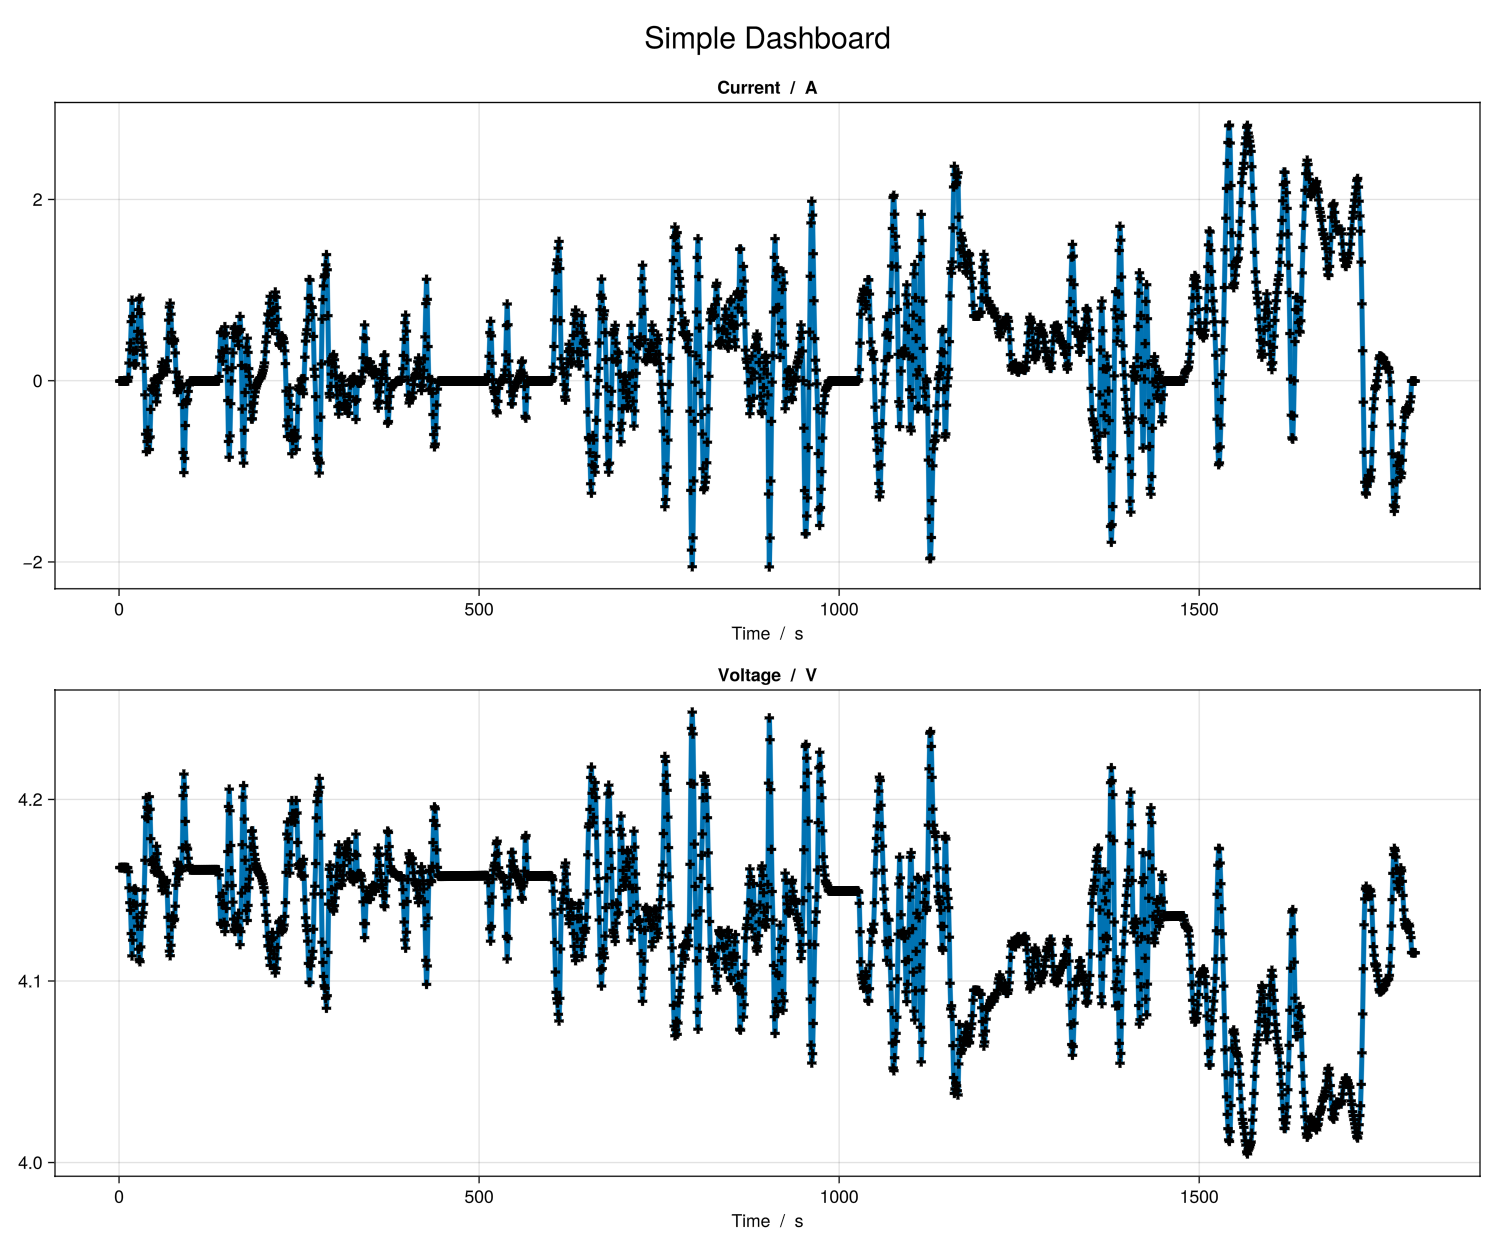

In [117]:
sim = Simulation(model_setup, cell_parameters, cycling_protocol; simulation_settings);

output = solve(sim);

plot_dashboard(output)


### c) Electrode balancing

In this tutorial, we will study the effects that electrode thicknesses have over the power delivered by a cell. Power capability is usually determined from the
loss in capacity when cycling the cell at higher rates. We will compare the effects of thickness on the power delivery of a cell. Let's load some default parameter sets and model settings.

In [118]:
cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/chen_2020.json")
cc_discharge_protocol = load_cycling_protocol(; from_file_path = "default_sets/cycling_protocols/cc_discharge.json")

model_setup = LithiumIonBattery();

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────


We will change the thickness of the positive electrode, and evaluate the cell capacity at different CRates. Lets define the DRates to use and the range of thicknesses to explore.

In [119]:
d_rates = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 2.5]
thicknesses = range(8.0e-5, 11.0e-5, length = 9)

8.0e-5:3.75e-6:0.00011

Now we loop through both DRates and thicknesses to run a simulation for each combination. For each simulation, we will calculate the discharge capacity, and store it for plotting.

In [120]:
power_rates = []
np_ratios = []

for thickness in thicknesses

	capacities = []
	
	cell_parameters["NegativeElectrode"]["Coating"]["Thickness"] = thickness
	n_to_p_ratio = compute_np_ratio(cell_parameters)
	push!(np_ratios, n_to_p_ratio)

	for d_rate in d_rates

		cc_discharge_protocol["DRate"] = d_rate
		sim = Simulation(model_setup, cell_parameters, cc_discharge_protocol)
		print("###### Simulation of thickness $thickness | d_rate $d_rate #########")
		output = solve(sim; info_level = -1)

		if length(output.states["Time"]) > 0 # if simulation is successful
			discharge_capacity = output.metrics["DischargeCapacity"][1]
			push!(capacities, discharge_capacity)
		else
			push!(capacities, 0.0)
		end
	end
	push!(power_rates, (thickness = thickness, d_rates = d_rates, capacities = capacities, np_ratios = n_to_p_ratio))
end

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.0e-5 | d_rate 0.05 #########✔️ Validation of SolverSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.0e-5 | d_rate 0.1 #########✔️ Validation of SolverSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Va

Excessive output truncated after 524340 bytes.

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────


Now we plot capacities vs Drate at different thicknesses of the negative electrode:

In [121]:
fig = Figure(size = (1000, 400))
ax = Axis(fig[1, 1], title = "Power capability vs Thickness of Negative Electrode",
          xlabel = "DRate", ylabel = "Capacity  /  Ah")

colors = resample_cmap(:managua, length(power_rates))

for (i, experiment) in enumerate(power_rates)
    label_str = lowercase(string(experiment.thickness*10^6))  # Scientific notation as string
    lines!(ax, experiment.d_rates, experiment.capacities, label = label_str, color=colors[i], linewidth = 5)
end

fig[1, 2] = Legend(fig, ax, "Thicknesses /  μm", framevisible = false)
fig


TaskFailedException: TaskFailedException

    nested task error: GLFWError (PLATFORM_ERROR): WGL: Failed to make context current: The operation completed successfully. 
    Stacktrace:
     [1] _ErrorCallbackWrapper(code::Int32, description::Cstring)
       @ GLFW C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\callback.jl:46
     [2] MakeContextCurrent
       @ C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\glfw3.jl:841 [inlined]
     [3] native_switch_context!
       @ C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\glwindow.jl:223 [inlined]
     [4] switch_context!
       @ C:\Users\lorenah\.julia\packages\ShaderAbstractions\BCZHP\src\context.jl:51 [inlined]
     [5] pollevents(screen::GLMakie.Screen{GLFW.Window}, frame_state::Makie.TickState)
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:545
     [6] on_demand_renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1038
     [7] renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1066
     [8] (::GLMakie.var"#start_renderloop!##0#start_renderloop!##1"{GLMakie.Screen{GLFW.Window}})()
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:927

We can observe in the plot the following feature:
* The cell capacity at low DRates grows quite linerarly with the thickness of the negative electrode up to a point. 
    * The capacity of the negative electrode at thicknesses below 105 um is lower than for the positive electrode. Therefore any increase in negative electrode thickness will increase the overall cell capacity.
    * However, then the thickness of the negative electrode surpass 105 um, additional thickness increase will not translate in additional cell capacity, as the positive electrode capacity becomes the limiting.

The interplay between electrode thicknesses and capacities can be better visualized if we plot the N:P ratios instead of the thicknesses. Lets do this below:

In [122]:
fig = Figure(size = (600, 400))
ax = Axis(fig[1, 1], title = "Power capability vs Thickness of Negative Electrode",
          xlabel = "DRate", ylabel = "Capacity  /  Ah")

colors = resample_cmap(:managua, length(power_rates))

for (i, experiment) in enumerate(power_rates)
    label_str = lowercase(string(round(experiment.np_ratios, digits=2)))  # Scientific notation as string
    lines!(ax, experiment.d_rates, experiment.capacities, label = label_str, color=colors[i], linewidth = 5)
end

fig[1, 2] = Legend(fig, ax, "N/P ratio", framevisible = false)
fig

TaskFailedException: TaskFailedException

    nested task error: GLFWError (PLATFORM_ERROR): WGL: Failed to make context current: The operation completed successfully. 
    Stacktrace:
     [1] _ErrorCallbackWrapper(code::Int32, description::Cstring)
       @ GLFW C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\callback.jl:46
     [2] MakeContextCurrent
       @ C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\glfw3.jl:841 [inlined]
     [3] native_switch_context!
       @ C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\glwindow.jl:223 [inlined]
     [4] switch_context!
       @ C:\Users\lorenah\.julia\packages\ShaderAbstractions\BCZHP\src\context.jl:51 [inlined]
     [5] pollevents(screen::GLMakie.Screen{GLFW.Window}, frame_state::Makie.TickState)
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:545
     [6] on_demand_renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1038
     [7] renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1066
     [8] (::GLMakie.var"#start_renderloop!##0#start_renderloop!##1"{GLMakie.Screen{GLFW.Window}})()
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:927

As the N:P ratio slightly exceeds 1.0, the cell capacity at low rate saturates. The saturation does not occur at NP=1.0 exactly, but slightly above 1.1. We think that thickness changes affect the alignment of half-cell OCPs, leading to an actual capacity that differs from that predicted solely by stoichiometric ranges and thicknesses.

At higher rates, we also observe:
* Cell capacities decrease, as overpotentials cause the lower potential limit to be reached before full capacity is delivered.
* This decrease is more pronounced with increasing NP ratios. Thicker electrodes extend the Li⁺ diffusion path within the porous structure, raising transport overpotentials and causing earlier cutoff.

## Part 3 - Parameter Calibration

Usually, the parameters we obtain from the characterization of the cell result in simulations that are off from cycling data. Therefore, before using a model, it is good practice to carry out a "Calibration" step, where we fit a small subset of the model parameters to experimental voltage profiles of the same cell.

In this session, we will calibrate the Xu 2025 parameter set to experimental voltage curves from the same cell. 

### Load the experimental data

We will calibrate our model in two steps: 
1. We will adjust the stoichiometric coefficients and maximum concentrations of the active materials, to fit a cell voltage curve at C/2.
2. We will adjust the reaction rate constants and diffusion coefficients in the active materials, to fit a cell voltage curve at 2C.

We first load the datasets.

In [153]:
expdata_05C = CSV.read("data/xu_2015_voltage_curve_05C.csv", DataFrame)
expdata_1C = CSV.read("data/xu_2015_voltage_curve_1C.csv", DataFrame)
expdata_2C = CSV.read("data/xu_2015_voltage_curve_2C.csv", DataFrame)

Row,t,V
,Float64,Float64
1,0.0,3.20968
2,110.725,3.15128
3,246.598,3.10993
4,394.822,3.10201
5,543.047,3.10273
6,691.272,3.10037
7,839.497,3.07889
8,963.018,3.05584
9,1086.54,3.00935


### Run a simulation of the original parameters
Now we run a baseline simulation using the parameters obtained only from characterization of the cell. We load the parameter set, ensure an appropiate lower voltage limit and DRate, and run the simulation as we saw in previous tutorials.

In [124]:
cell_parameters_original = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/xu_2015.json")
cycling_protocol = load_cycling_protocol(; from_default_set = "cc_discharge")

cycling_protocol["LowerVoltageLimit"] = 2.25
cycling_protocol["DRate"] = 0.5

model_setup = LithiumIonBattery()

sim_original = Simulation(model_setup, cell_parameters_original, cycling_protocol)
output_original = solve(sim_original);


Once the simulation completes, we can inspect the resutling voltage curves, and compare them with the experimental voltage curves.

In [125]:
#Simulation data
time_series = output_original.time_series
simdata_time_original = time_series["Time"]
simdata_voltage_original = time_series["Voltage"]

#Plot
fig = Figure()
ax = Axis(fig[1, 1], title = "CRate = 0.5", xlabel = "Time / s", ylabel = "Voltage / V")
lines!(ax, simdata_time_original, simdata_voltage_original, label = "Simulation 0.5C: original parameters")
scatter!(ax, expdata_05C[:,1], expdata_05C[:,2], label = "Experimental data 0.5C", markersize = 20)
axislegend(position = :lb)
fig

TaskFailedException: TaskFailedException

    nested task error: GLFWError (PLATFORM_ERROR): WGL: Failed to make context current: The operation completed successfully. 
    Stacktrace:
     [1] _ErrorCallbackWrapper(code::Int32, description::Cstring)
       @ GLFW C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\callback.jl:46
     [2] MakeContextCurrent
       @ C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\glfw3.jl:841 [inlined]
     [3] native_switch_context!
       @ C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\glwindow.jl:223 [inlined]
     [4] switch_context!
       @ C:\Users\lorenah\.julia\packages\ShaderAbstractions\BCZHP\src\context.jl:51 [inlined]
     [5] pollevents(screen::GLMakie.Screen{GLFW.Window}, frame_state::Makie.TickState)
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:545
     [6] on_demand_renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1038
     [7] renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1066
     [8] (::GLMakie.var"#start_renderloop!##0#start_renderloop!##1"{GLMakie.Screen{GLFW.Window}})()
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:927

We can see that the simulation with original parameters does not match well the experiment. Lets therefore fit some parameters to the experimental data.

### Low-rate Calibration

We have developed a calibration function that takes as inputs the voltage and time arrays of the data, along with the initial simulation setup.

In [126]:
calibration_low_rate = VoltageCalibration(expdata_05C[:,1], expdata_05C[:,2], sim_original); #  VoltageCalibration(experimental_time, experimental_voltage, simulation)

This calibration object is a handy way to tailor the main settings needed to run a calibration: 
* Which model parameters are frozen
* Which model parameters are being fitted
* What are the minimum and maximum bounds of the parameters to be fitted
* The results of the calibration, i.e. the optimal parameters.

**All paramters are frozen by default**, so we now need to free those we are interested in, and apply some bounds to each to ensure they remain within expected ranges. Below, we free the stoichiometric coefficients and maximum concentrations.

In [127]:
free_calibration_parameter!(calibration_low_rate,
    ["NegativeElectrode","ActiveMaterial", "StoichiometricCoefficientAtSOC100"];
    lower_bound = 0.0, upper_bound = 1.0)
free_calibration_parameter!(calibration_low_rate,
    ["PositiveElectrode","ActiveMaterial", "StoichiometricCoefficientAtSOC100"];
    lower_bound = 0.0, upper_bound = 1.0)

# "StoichiometricCoefficientAtSOC0" at both electrodes
free_calibration_parameter!(calibration_low_rate,
    ["NegativeElectrode","ActiveMaterial", "StoichiometricCoefficientAtSOC0"];
    lower_bound = 0.0, upper_bound = 1.0)
free_calibration_parameter!(calibration_low_rate,
    ["PositiveElectrode","ActiveMaterial", "StoichiometricCoefficientAtSOC0"];
    lower_bound = 0.0, upper_bound = 1.0)

#  "MaximumConcentration" of both electrodes
free_calibration_parameter!(calibration_low_rate,
    ["NegativeElectrode","ActiveMaterial", "MaximumConcentration"];
    lower_bound = 10000.0, upper_bound = 1e5)
free_calibration_parameter!(calibration_low_rate,
    ["PositiveElectrode","ActiveMaterial", "MaximumConcentration"];
    lower_bound = 10000.0, upper_bound = 1e5);

We have a handy function to check parameter, values and bounds:

In [128]:
print_info(calibration_low_rate)

Solving the calibration problem is essentially an optimization problem. We adjust free parameters so to minimize the difference between a target (the data) and the prediction (the simulation result): is performed by solving the optimization problem. This makes use of the adjoint method implemented in Jutul.jl and the LBFGS algorithm.

For calibration, we minimize the squared difference between the predicted and observed voltage, summed over all time steps:  
                  $\sum_i (V_i - V_{exp,i})^2$  
where $V_i$ is the voltage from the model and $V_{exp,i}$ is the voltage from the experimental data at step $i$. This minimization uses in the background cool algorithms implemented in Jutul, the simulation engine of BattMo. 

In [129]:
solve(calibration_low_rate);
cell_parameters_calibrated_low_rate = calibration_low_rate.calibrated_cell_parameters;

We can use the same printing function to explore the results of the simulation

In [130]:
print_info(calibration_low_rate)

We can now use the optimized parameters to run a new simulation, and compare the results to the experimental data for the 0.5C discharge curve.

In [131]:
#Setup and run simulation
sim_calibrated_low_rate = Simulation(model_setup, cell_parameters_calibrated_low_rate, cycling_protocol)
output_calibrated_low_rate = solve(sim_calibrated_low_rate);

#Get simulation data
time_series = output_calibrated_low_rate.time_series
simdata_time_calibrated_low_rate = time_series["Time"]
simdata_voltage_calibrated_low_rate = time_series["Voltage"]

#Plot
fig = Figure()
ax = Axis(fig[1, 1], title = "CRate = 0.5")
lines!(ax, simdata_time_original, simdata_voltage_original, label = "Simulation 0.5C: Original parameters")
lines!(ax, simdata_time_calibrated_low_rate, simdata_voltage_calibrated_low_rate, label = "Simulation 0.5C: after low rate calibration")
scatter!(ax, expdata_05C[:,1], expdata_05C[:,2], label = "Experimental data 0.5C", markersize = 20)
axislegend(position = :lb)
fig

TaskFailedException: TaskFailedException

    nested task error: GLFWError (PLATFORM_ERROR): WGL: Failed to make context current: The operation completed successfully. 
    Stacktrace:
     [1] _ErrorCallbackWrapper(code::Int32, description::Cstring)
       @ GLFW C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\callback.jl:46
     [2] MakeContextCurrent
       @ C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\glfw3.jl:841 [inlined]
     [3] native_switch_context!
       @ C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\glwindow.jl:223 [inlined]
     [4] switch_context!
       @ C:\Users\lorenah\.julia\packages\ShaderAbstractions\BCZHP\src\context.jl:51 [inlined]
     [5] pollevents(screen::GLMakie.Screen{GLFW.Window}, frame_state::Makie.TickState)
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:545
     [6] on_demand_renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1038
     [7] renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1066
     [8] (::GLMakie.var"#start_renderloop!##0#start_renderloop!##1"{GLMakie.Screen{GLFW.Window}})()
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:927

### High-rate Calibration

The second calibration is performed against the 2.0C discharge curve. In the same manner as for the first discharge curve, we set up a set of parameters to calibrate against experimental data. The parameters are:

 - The reaction rate constant of both electrodes
 - The diffusion coefficient of both electrodes

The calibration this time starts from the parameters calibrated at 0.5C, so we use the `cell_parameters_calibrated_05C` from the first `solve` to run a new simulation at 2C:

In [132]:
#Update cycling protocol to run at 2C
cycling_protocol2 = deepcopy(cycling_protocol)
cycling_protocol2["DRate"] = 2.0

#Solve simulation with parameters calibrated at 05C but running a 2C discharge protocol
sim_calibrated_low_rate = Simulation(model_setup, cell_parameters_calibrated_low_rate, cycling_protocol2)
output_calibrated_low_rate = solve(sim_calibrated_low_rate);

#Get simulation data of parameters calibrated at 0.5C but run at 2C
time_series = output_calibrated_low_rate.time_series
simdata_time_calibrated_low_rate = time_series["Time"]
simdata_voltage_calibrated_low_rate = time_series["Voltage"]

37-element Vector{Float64}:
 3.3402815648223405
 3.2696438872066893
 3.213365850900803
 3.2103606433459007
 3.2065989909406607
 3.203401811165377
 3.2015839805732482
 3.1997958755583267
 3.1973433084086325
 3.193872208125065
 ⋮
 3.0344525746325375
 3.016235291753052
 2.9951279040004533
 2.9712465522768294
 2.937996922470595
 2.880266848931671
 2.8064735213359504
 2.6483959734302625
 2.288163880644116

We use the simulation at 2C ran with the parameter set calibrated at 0.5C as a starting point for our new high rate calibration task. 

This time we free the reaction rate constants and diffusion coefficients, and set some boundaries for each.

In [133]:
calibration_high_rate = VoltageCalibration(expdata_2C[:,1], expdata_2C[:,2], sim_calibrated_low_rate)

free_calibration_parameter!(calibration_high_rate,
    ["NegativeElectrode","ActiveMaterial", "ReactionRateConstant"];
    lower_bound = 1e-16, upper_bound = 1e-10)
free_calibration_parameter!(calibration_high_rate,
    ["PositiveElectrode","ActiveMaterial", "ReactionRateConstant"];
    lower_bound = 1e-16, upper_bound = 1e-10)

free_calibration_parameter!(calibration_high_rate,
    ["NegativeElectrode","ActiveMaterial", "DiffusionCoefficient"];
    lower_bound = 1e-16, upper_bound = 1e-12)
free_calibration_parameter!(calibration_high_rate,
    ["PositiveElectrode","ActiveMaterial", "DiffusionCoefficient"];
    lower_bound = 1e-16, upper_bound = 1e-12)

print_info(calibration_high_rate)

Solve the high-rate calibration problem

In [134]:
cell_parameters_calibrated_high_rate, = solve(calibration_high_rate);
print_info(calibration_high_rate)

We compare three simulations against the experimental data:
 1. The initial simulation with the original parameters.
 2. The simulation with the parameters calibrated against the 0.5C discharge curve.
 3. The simulation with the parameters calibrated against the 0.5C and 2.0C discharge curves.

In [135]:
# Simulation at 2C  using original parameters
sim_original_params = Simulation(model_setup, cell_parameters_original, cycling_protocol2)
output_original_params = solve(sim_original_params, accept_invalid = false);
 
time_series = output_original_params.time_series
simdata_time_original_params = time_series["Time"]
simdata_voltage_original_params = time_series["Voltage"]


# Simulation at 2C using calibrated parameters from 2C calibration
sim_calibrated_high_rate = Simulation(model_setup, cell_parameters_calibrated_high_rate, cycling_protocol2)
output_calibrated_high_rate = solve(sim_calibrated_high_rate, accept_invalid = false);
 
time_series = output_calibrated_high_rate.time_series
simdata_time_calibrated_high_rate = time_series["Time"]
simdata_voltage_calibrated_high_rate = time_series["Voltage"]

# Plot 2C calibrated model vs 2C experimental data
fig = Figure()
ax = Axis(fig[1, 1], title = "CRate = 2.0")
lines!(ax, simdata_time_original_params, simdata_voltage_original_params, label = "Simulation 2C: Original parameters")
lines!(ax, simdata_time_calibrated_low_rate, simdata_voltage_calibrated_low_rate, label = "Simulation 2C: after low-rate calibration")
lines!(ax, simdata_time_calibrated_high_rate, simdata_voltage_calibrated_high_rate, label = "Simulation 2C: after high-rate calibration")
scatter!(ax, expdata_2C[:,1], expdata_2C[:,2], label = "Experimental data 2C", markersize = 20)
axislegend(position = :lb)
fig

TaskFailedException: TaskFailedException

    nested task error: GLFWError (PLATFORM_ERROR): WGL: Failed to make context current: The operation completed successfully. 
    Stacktrace:
     [1] _ErrorCallbackWrapper(code::Int32, description::Cstring)
       @ GLFW C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\callback.jl:46
     [2] MakeContextCurrent
       @ C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\glfw3.jl:841 [inlined]
     [3] native_switch_context!
       @ C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\glwindow.jl:223 [inlined]
     [4] switch_context!
       @ C:\Users\lorenah\.julia\packages\ShaderAbstractions\BCZHP\src\context.jl:51 [inlined]
     [5] pollevents(screen::GLMakie.Screen{GLFW.Window}, frame_state::Makie.TickState)
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:545
     [6] on_demand_renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1038
     [7] renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1066
     [8] (::GLMakie.var"#start_renderloop!##0#start_renderloop!##1"{GLMakie.Screen{GLFW.Window}})()
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:927

### Calibrated model at all CRates

We can now compare the results of the model after both low-rate and high-rate calibration against the experimental data for the 0.5C, 1.0C, and 2.0C discharge curves. 

> **Note that we did not calibrate the model for the 1.0C discharge curve, but we still obtain a good fit!!**

In [136]:
CRates = [0.5, 1.0, 2.0]
colors = Dict(0.5 => :firebrick1, 1.0 => :teal, 2.0 => :dodgerblue4)

fig = Figure()
ax = Axis(fig[1, 1], title = "Simulations vs. Experiments: after calibration")
scatter!(ax, expdata_05C[:,1], expdata_05C[:,2], label = "Experimental data 0.5C", markersize = 15, color = colors[0.5])
scatter!(ax, expdata_1C[:,1], expdata_1C[:,2], label = "Experimental data 1C", markersize = 15, color =colors[1.0])
scatter!(ax, expdata_2C[:,1], expdata_2C[:,2], label = "Experimental data 2C", markersize = 15, color =colors[2.0])

for CRate in CRates
    #Setup and run simulation
    cycling_protocol["DRate"] = CRate
    sim = Simulation(model_setup, cell_parameters_calibrated_high_rate, cycling_protocol)
    output = solve(sim, info_level = -1)

    #Get time series quantities from simulation result
    t = output.time_series["Time"]
    V = output.time_series["Voltage"]

    #Plot simulation voltage response
    lines!(ax, t, V, label = "Simulation $CRate: after high-rate calibration", color = colors[CRate])
end  

axislegend(position = :lb)
fig

TaskFailedException: TaskFailedException

    nested task error: GLFWError (PLATFORM_ERROR): WGL: Failed to make context current: The operation completed successfully. 
    Stacktrace:
     [1] _ErrorCallbackWrapper(code::Int32, description::Cstring)
       @ GLFW C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\callback.jl:46
     [2] MakeContextCurrent
       @ C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\glfw3.jl:841 [inlined]
     [3] native_switch_context!
       @ C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\glwindow.jl:223 [inlined]
     [4] switch_context!
       @ C:\Users\lorenah\.julia\packages\ShaderAbstractions\BCZHP\src\context.jl:51 [inlined]
     [5] pollevents(screen::GLMakie.Screen{GLFW.Window}, frame_state::Makie.TickState)
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:545
     [6] on_demand_renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1038
     [7] renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1066
     [8] (::GLMakie.var"#start_renderloop!##0#start_renderloop!##1"{GLMakie.Screen{GLFW.Window}})()
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:927

## Part 4 - P4D Simulations

This example demonstrates how to set up, run and visualize a 3D cylindrical battery model. Let's first load the parameters and settings that we need and instantiate the model setup.


In [137]:
cell_parameters     = load_cell_parameters(; from_default_set = "chen_2020")
cycling_protocol    = load_cycling_protocol(; from_default_set = "cc_discharge")
simulation_settings = load_simulation_settings(; from_default_set = "p4d_cylindrical")

model_settings      = load_model_settings(; from_default_set = "p4d_cylindrical")

model_setup = LithiumIonBattery(; model_settings)

LithiumIonBattery("Setup object for a P4D Cylindrical lithium-ion model", {
    "ButlerVolmer" => "Standard"
    "CurrentCollectors" => "Standard"
    "RampUp" => "Sinusoidal"
    "Metadata" =>     {
        "Description" => "Default model settings for a P4D cylindrical cell with a current ramp up."
        "Title" => "P4D Cylindrical"
    }
    "PotentialFlowDiscretization" => "GeneralAD"
    "TransportInSolid" => "FullDiffusion"
    "ModelFramework" => "P4D Cylindrical"
}, true, #undef)

Let's review and modify the cell parameters. We go through some of the geometrical and discretization parameters. We modify some of them to obtain a cell where the different components are easier to visualize

In [138]:
cell_parameters["Cell"]["OuterRadius"] = 0.010 

0.01

We modify the current collector thicknesses, for visualization purpose

In [139]:
cell_parameters["NegativeElectrode"]["CurrentCollector"]["Thickness"]    = 50e-6
cell_parameters["PositiveElectrode"]["CurrentCollector"]["Thickness"]    = 50e-6

5.0e-5

The tabs are part of the current collectors that connect the electrodes to the external circuit. The location of the tabs is given as a fraction length, where the length is measured along the current collector in the horizontal direction, meaning that we follow the rolling spiral. Indeed, this is the relevant length to use if we want to dispatch the current collector in a equilibrated way, where each of them will a priori collect the same amount of current. In the following, we include three tabs with one in the middle and the other at a distance such that each tab will collect one third of the current.

In [140]:
cell_parameters["NegativeElectrode"]["CurrentCollector"]["TabFractions"] = [0.5/3, 0.5, 0.5 + 0.5/3] 
cell_parameters["PositiveElectrode"]["CurrentCollector"]["TabFractions"] = [0.5/3, 0.5, 0.5 + 0.5/3]

3-element Vector{Float64}:
 0.16666666666666666
 0.5
 0.6666666666666666

We set the tab width to 2 mm.

In [141]:
cell_parameters["NegativeElectrode"]["CurrentCollector"]["TabWidth"] = 0.002
cell_parameters["PositiveElectrode"]["CurrentCollector"]["TabWidth"] = 0.002

0.002

The angular discretization of the cell is determined by the number of angular grid points.

In [142]:
simulation_settings["AngularGridPoints"] = 30

30

Create the simulation object.

In [143]:
sim = Simulation(model_setup, cell_parameters, cycling_protocol; simulation_settings);

We preprocess the simulation object to retrieve the grids and coupling structure, which we want to visualize prior running the simulation.

In [144]:
grids     = sim.grids
couplings = sim.couplings

Dict{String, Dict{String, Any}} with 6 entries:
  "Electrolyte"              => {…
  "NegativeCurrentCollector" => {…
  "PositiveElectrode"        => {…
  "PositiveCurrentCollector" => {…
  "Separator"                => {…
  "NegativeElectrode"        => {…

Let's visualize the grids and couplings. Define a list of the component to iterate over in the ploting routin below.

In [145]:
components = ["NegativeElectrode", "PositiveElectrode", "NegativeCurrentCollector", "PositiveCurrentCollector" ]
colors = [:gray, :green, :blue, :black]

4-element Vector{Symbol}:
 :gray
 :green
 :blue
 :black

In [146]:
for (i, component) in enumerate(components)
    if i == 1
        global fig, ax = plot_mesh(grids[component],
                            color = colors[i])
    else
        plot_mesh!(ax,
                   grids[component],
                   color = colors[i])
    end
end
fig

TaskFailedException: TaskFailedException

    nested task error: GLFWError (PLATFORM_ERROR): WGL: Failed to make context current: The operation completed successfully. 
    Stacktrace:
     [1] _ErrorCallbackWrapper(code::Int32, description::Cstring)
       @ GLFW C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\callback.jl:46
     [2] MakeContextCurrent
       @ C:\Users\lorenah\.julia\packages\GLFW\Zwulj\src\glfw3.jl:841 [inlined]
     [3] native_switch_context!
       @ C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\glwindow.jl:223 [inlined]
     [4] switch_context!
       @ C:\Users\lorenah\.julia\packages\ShaderAbstractions\BCZHP\src\context.jl:51 [inlined]
     [5] pollevents(screen::GLMakie.Screen{GLFW.Window}, frame_state::Makie.TickState)
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:545
     [6] on_demand_renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1038
     [7] renderloop(screen::GLMakie.Screen{GLFW.Window})
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:1066
     [8] (::GLMakie.var"#start_renderloop!##0#start_renderloop!##1"{GLMakie.Screen{GLFW.Window}})()
       @ GLMakie C:\Users\lorenah\.julia\packages\GLMakie\1dQSN\src\screen.jl:927

We plot the tabs, which couple the current collectors with the external circuits. The tabs will typically protude from the cell in the vertical directions but we can neglect this 3d feature in the simulation model. The tabs are then represented by horizontal faces at the top or bottom of the current collectors. In the figure below, they are plotted in red.

In [147]:
components = [
    "NegativeCurrentCollector",
    "PositiveCurrentCollector"
]

for component in components
    plot_mesh!(ax, grids[component];
               boundaryfaces = couplings[component]["External"]["boundaryfaces"],
               color = :red)
end

fig #hide

ax.azimuth[] = 4.0
ax.elevation[] = 1.56

fig

FieldError: FieldError: type Axis has no field `azimuth`, available fields: `parent`, `layoutobservables`, `blockscene`, `scene`, `xaxislinks`, `yaxislinks`, `targetlimits`, `finallimits`, `block_limit_linking`, `mouseeventhandle`, `scrollevents`, `keysevents`, `interactions`, `xaxis`, `yaxis`, `elements`, `dim1_conversion`, `dim2_conversion`, `xlabel`, `ylabel`, `title`, `titlefont`, `titlesize`, `titlegap`, `titlevisible`, `titlealign`, `titlecolor`, `titlelineheight`, `subtitle`, `subtitlefont`, `subtitlesize`, `subtitlegap`, `subtitlevisible`, `subtitlecolor`, `subtitlelineheight`, `xlabelfont`, `ylabelfont`, `xlabelcolor`, `ylabelcolor`, `xlabelsize`, `ylabelsize`, `xlabelvisible`, `ylabelvisible`, `xlabelpadding`, `ylabelpadding`, `xlabelrotation`, `ylabelrotation`, `xticklabelfont`, `yticklabelfont`, `xticklabelcolor`, `yticklabelcolor`, `xticklabelsize`, `yticklabelsize`, `xticklabelsvisible`, `yticklabelsvisible`, `xticklabelspace`, `yticklabelspace`, `xticklabelpad`, `yticklabelpad`, `xticklabelrotation`, `yticklabelrotation`, `xticklabelalign`, `yticklabelalign`, `xticksize`, `yticksize`, `xticksvisible`, `yticksvisible`, `xtickalign`, `ytickalign`, `xtickwidth`, `ytickwidth`, `xtickcolor`, `ytickcolor`, `xticksmirrored`, `yticksmirrored`, `xpanlock`, `ypanlock`, `xzoomlock`, `yzoomlock`, `xrectzoom`, `yrectzoom`, `spinewidth`, `xgridvisible`, `ygridvisible`, `xgridwidth`, `ygridwidth`, `xgridcolor`, `ygridcolor`, `xgridstyle`, `ygridstyle`, `xminorgridvisible`, `yminorgridvisible`, `xminorgridwidth`, `yminorgridwidth`, `xminorgridcolor`, `yminorgridcolor`, `xminorgridstyle`, `yminorgridstyle`, `bottomspinevisible`, `leftspinevisible`, `topspinevisible`, `rightspinevisible`, `bottomspinecolor`, `leftspinecolor`, `topspinecolor`, `rightspinecolor`, `aspect`, `valign`, `halign`, `width`, `height`, `tellwidth`, `tellheight`, `xautolimitmargin`, `yautolimitmargin`, `xticks`, `xtickformat`, `yticks`, `ytickformat`, `panbutton`, `xpankey`, `ypankey`, `xzoomkey`, `yzoomkey`, `zoombutton`, `xaxisposition`, `yaxisposition`, `xtrimspine`, `ytrimspine`, `backgroundcolor`, `flip_ylabel`, `autolimitaspect`, `limits`, `alignmode`, `yreversed`, `xreversed`, `xminorticksvisible`, `xminortickalign`, `xminorticksize`, `xminortickwidth`, `xminortickcolor`, `xminorticks`, `yminorticksvisible`, `yminortickalign`, `yminorticksize`, `yminortickwidth`, `yminortickcolor`, `yminorticks`, `xscale`, `yscale`

We reload the original parameters

In [148]:
cell_parameters     = load_cell_parameters(; from_default_set = "chen_2020")
cycling_protocol    = load_cycling_protocol(; from_default_set = "cc_discharge")
model_settings      = load_model_settings(; from_default_set = "p4d_cylindrical")
simulation_settings = load_simulation_settings(; from_default_set = "p4d_cylindrical")

{
    "TimeStepDuration" => 50
    "RampUpTime" => 10
    "HeightGridPoints" => 2
    "PositiveElectrodeCurrentCollectorGridPoints" => 3
    "PositiveElectrodeCurrentCollectorTabWidthGridPoints" => 2
    "PositiveElectrodeParticleGridPoints" => 5
    "PositiveElectrodeCoatingGridPoints" => 3
    "SeparatorGridPoints" => 3
    "RampUpSteps" => 5
    "NegativeElectrodeCurrentCollectorGridPoints" => 3
    "AngularGridPoints" => 8
    "NegativeElectrodeCurrentCollectorTabWidthGridPoints" => 2
    "NegativeElectrodeCoatingGridPoints" => 3
    "NegativeElectrodeParticleGridPoints" => 5
}

We adjust the parameters so that the simulation in this example is not too long (around a couple of minutes)

In [149]:
cell_parameters["Cell"]["OuterRadius"] = 0.004 
cell_parameters["NegativeElectrode"]["CurrentCollector"]["TabFractions"] = [0.5] 
cell_parameters["PositiveElectrode"]["CurrentCollector"]["TabFractions"] = [0.5] 
cell_parameters["NegativeElectrode"]["CurrentCollector"]["TabWidth"]     = 0.002
cell_parameters["PositiveElectrode"]["CurrentCollector"]["TabWidth"]     = 0.002
simulation_settings["AngularGridPoints"] = 8

8

We setup the simulation and run it

In [150]:
sim = Simulation(model_setup, cell_parameters, cycling_protocol; simulation_settings);
output = solve(sim; info_level = -1);

Let's plot the voltage and current profiles.

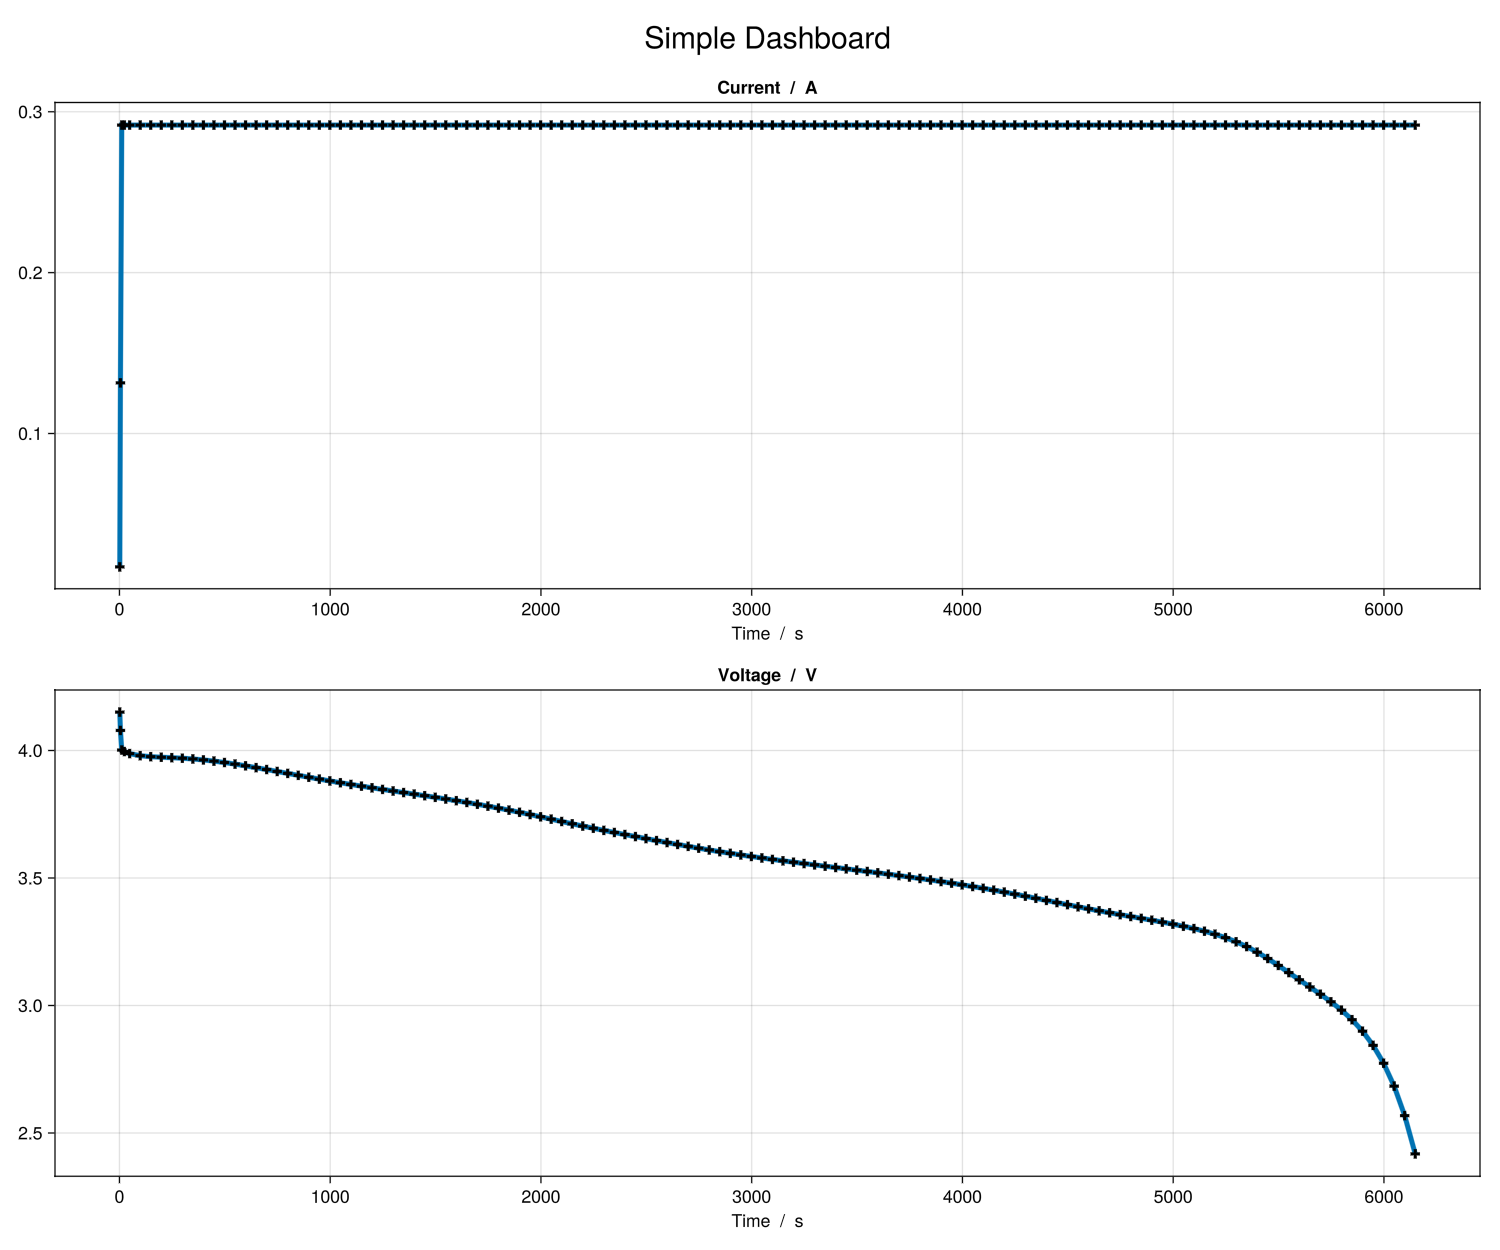

In [151]:
plot_dashboard(output; plot_type = "simple")

To show the results on the 3D geometry we have a really cool tool using Jutul that can be executed by the folowing function.

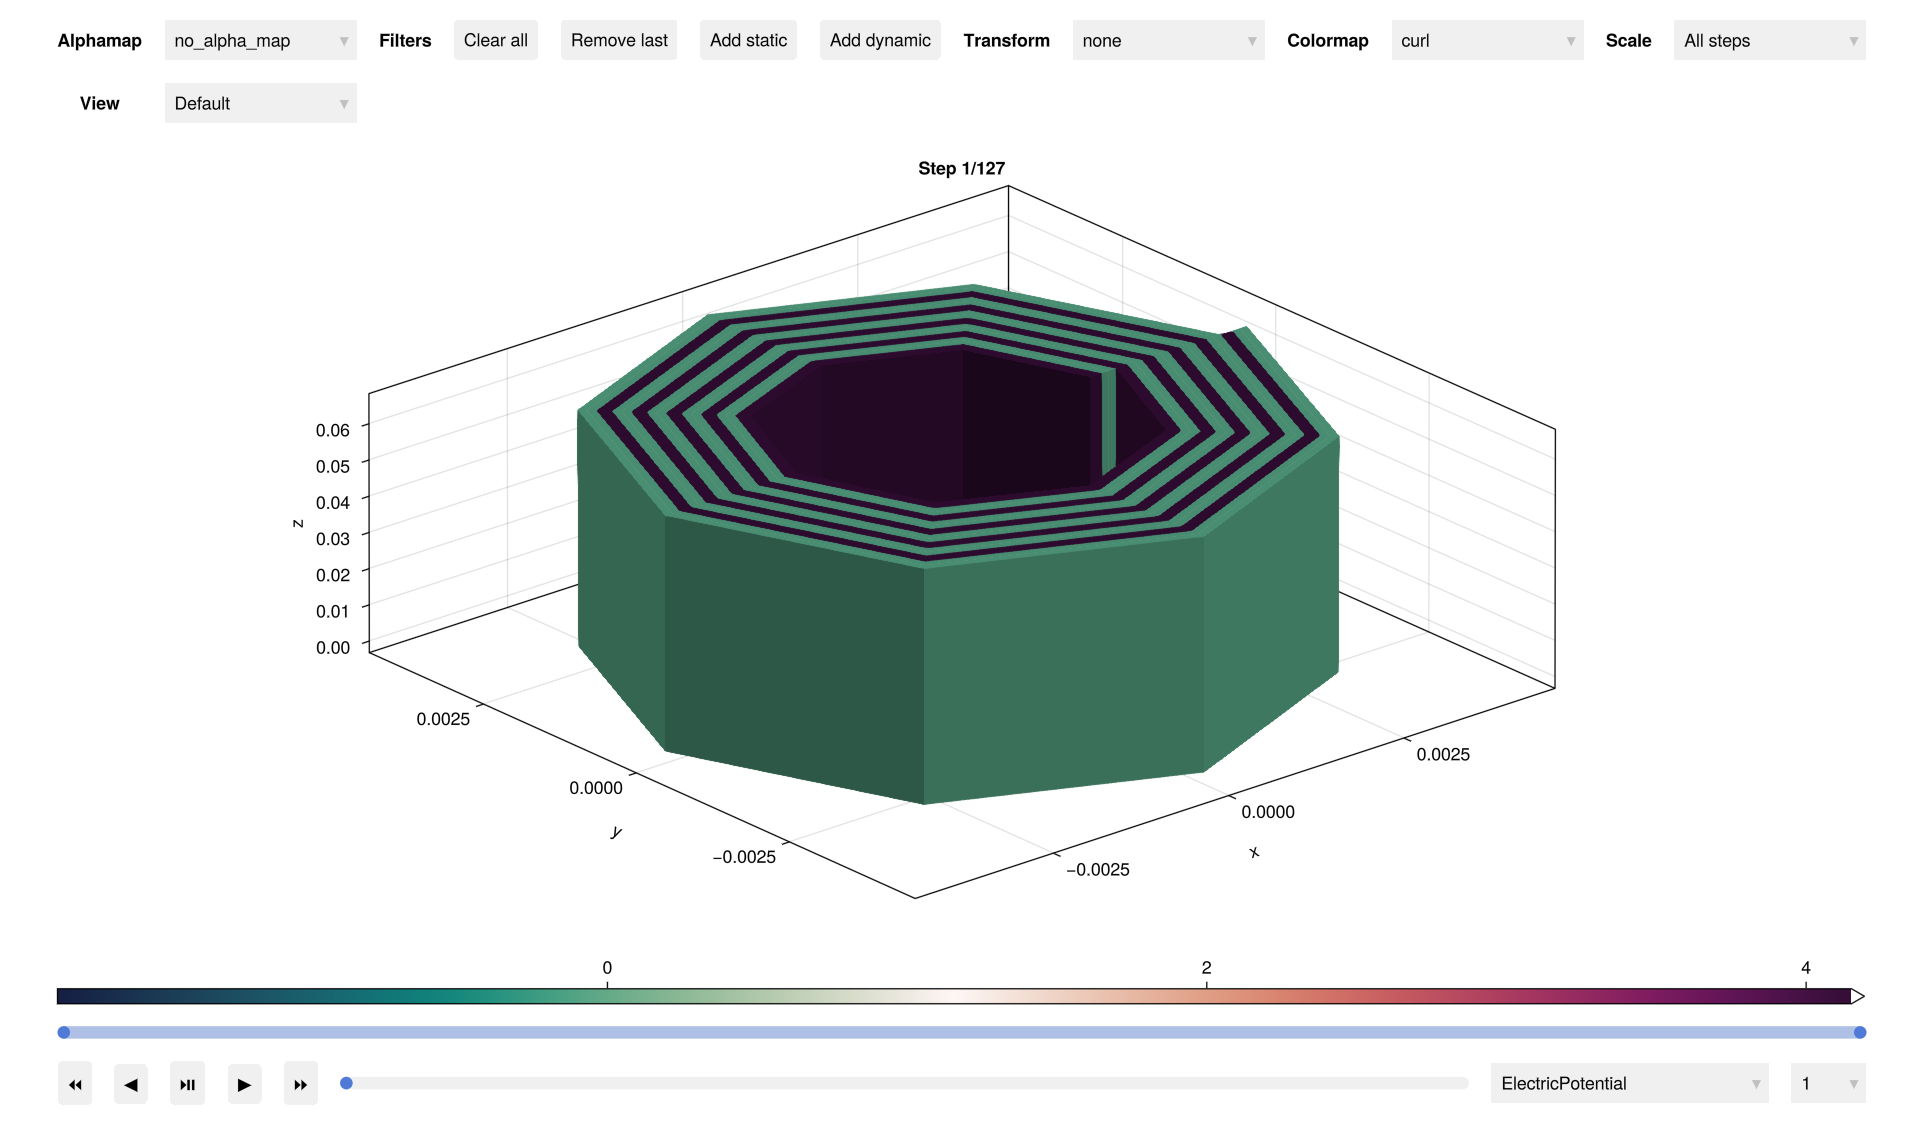

In [ ]:
GLMakie.activate!(inline=false)
plot_interactive_3d(output; colormap = :curl)